<a href="https://colab.research.google.com/github/StefanoBergia/Tesi_Anomaly_Detection/blob/main/UNSUPERVISED_ANOMALY_DETECTION_PROPHET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LIBRERIE

In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
#import plotly.express as px
#import plotly.graph_objects as go
from google.colab import drive
from google.colab import widgets
from plotly.subplots import make_subplots
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import add_changepoints_to_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import matplotlib.colors as mcolors
import datetime
import time
import warnings

#from statsmodels.tools.sm_exceptions import ConvergenceWarning
#from statsmodels.tools.sm_exceptions import UserWarning

colors=mcolors.TABLEAU_COLORS
colormap=np.array(list(list(zip(*colors.items()))[1]))
colormap=np.concatenate((colormap, colormap[1:],colormap[1:]), axis=0)
#print(colormap)
#!pip install pmdarima
#from pmdarima import auto_arima

DATASET

In [39]:
min_date='2021-07-24 00:00:00'
max_date='2021-08-27 23:59:00'

drive.mount('/content/gdrive',force_remount=True)
df_original = pd.read_csv('/content/gdrive/MyDrive/Dati_Tesi/PIVOT_WLS_HVST_1_MONTH.csv', parse_dates=['TS'], index_col='TS')
df_original.index = pd.DatetimeIndex(df_original.index)
df_original=df_original.asfreq(freq='60s',method='ffill')
df=df_original.copy()
df=df.loc[min_date:max_date]

columns=df.columns.drop(['431','907']).drop(['436','480','482','777','781','783','910'])

###########
#columns=['272']
##########

period_length=1440

print(columns)

Mounted at /content/gdrive
Index(['272', '430', '776', '780', '782', '784', '908', '909'], dtype='object')


*   272: OpenSocketsCurrentCount
*   430: OpenSessionCurrentCount
*   480: CompletedRequests
*   482: PendingRequests
*   776: ExecuteThreadIdleCount (sono pronti per essere eseguiti ma attendono un task)
*   777: ExecuteThreadTotalCount
*   780: PendingUserRequestCount
*   782: StandByThreadCount (sono in stato di wait di una risorsa)
*   784: Througput (mean number of request completed per second
*   908: HeapFreePercent
*   909 HeapSizeCurrent






In [40]:
df.head()

272  430  431  ...  908         909         910
TS                                  ...                             
2021-07-24 00:00:36    3   17  224  ...   74  8272216064  8272216064
2021-07-24 00:01:36    3   17  224  ...   74  8272216064  8272216064
2021-07-24 00:02:36    3   17  224  ...   74  8272216064  8272216064
2021-07-24 00:03:36    3   17  224  ...   74  8272216064  8272216064
2021-07-24 00:04:36    3   17  224  ...   74  8272216064  8272216064

[5 rows x 17 columns]

In [41]:
df.tail()

272  430  431  ...  908         909         910
TS                                  ...                             
2021-08-27 23:54:36    3   31  188  ...   73  8158445568  8158445568
2021-08-27 23:55:36    3   31  188  ...   73  8158445568  8158445568
2021-08-27 23:56:36    3   31  188  ...   73  8158445568  8158445568
2021-08-27 23:57:36    3   29  188  ...   73  8158445568  8158445568
2021-08-27 23:58:36    4   31  188  ...   72  8158445568  8158445568

[5 rows x 17 columns]

In [42]:
print(len(df.index))

50399


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

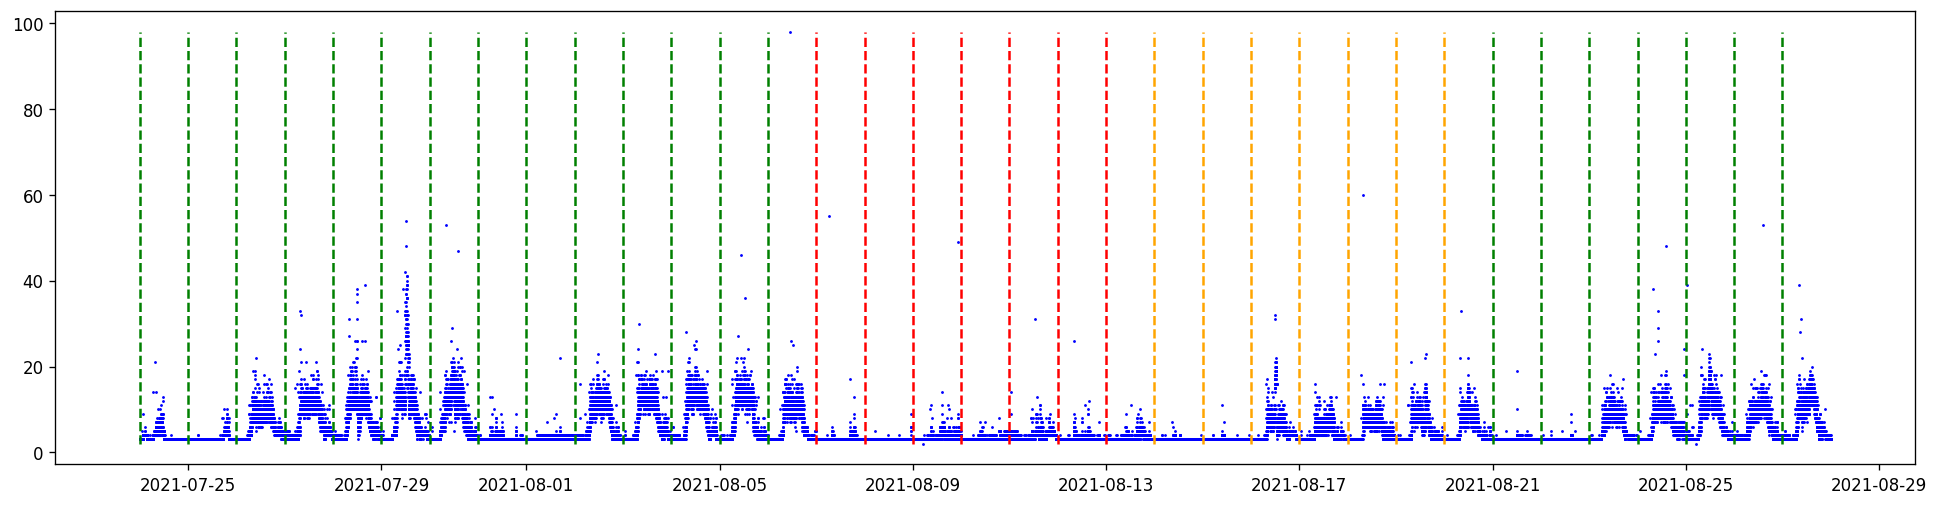

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

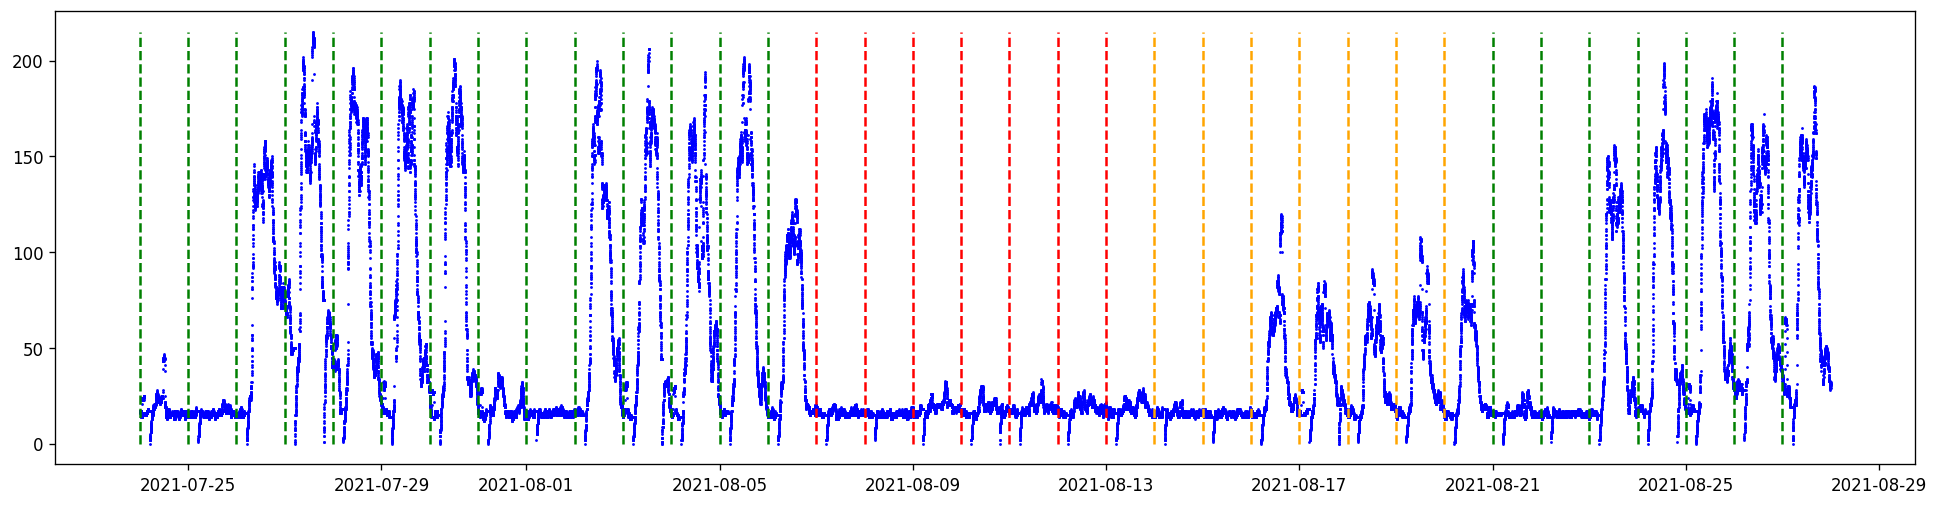

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

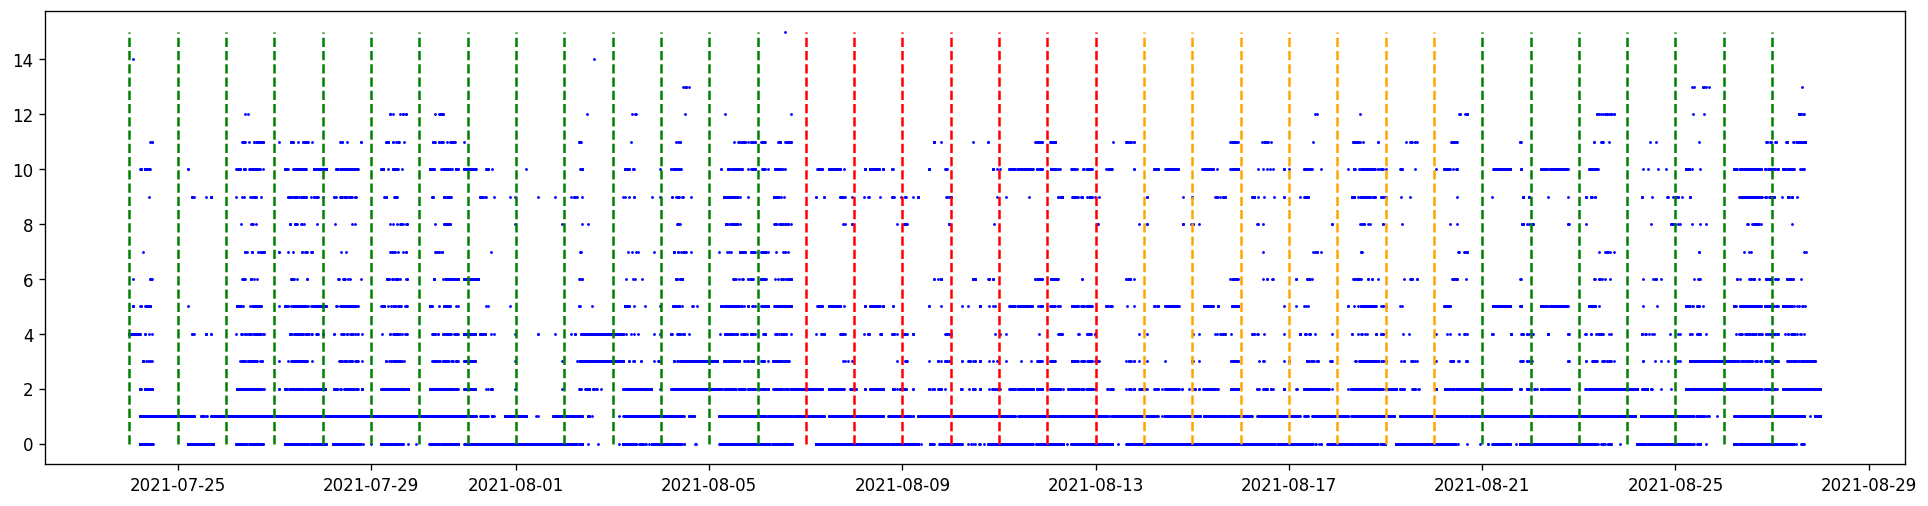

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

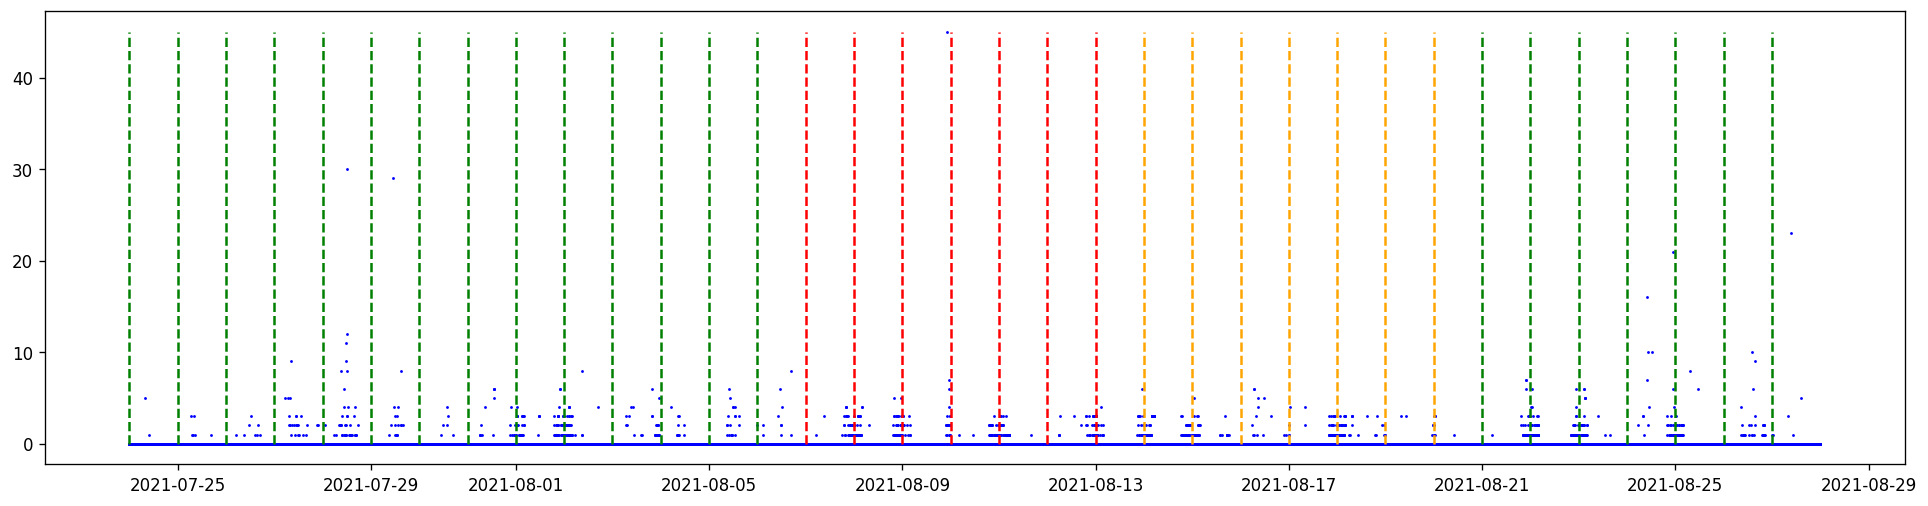

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

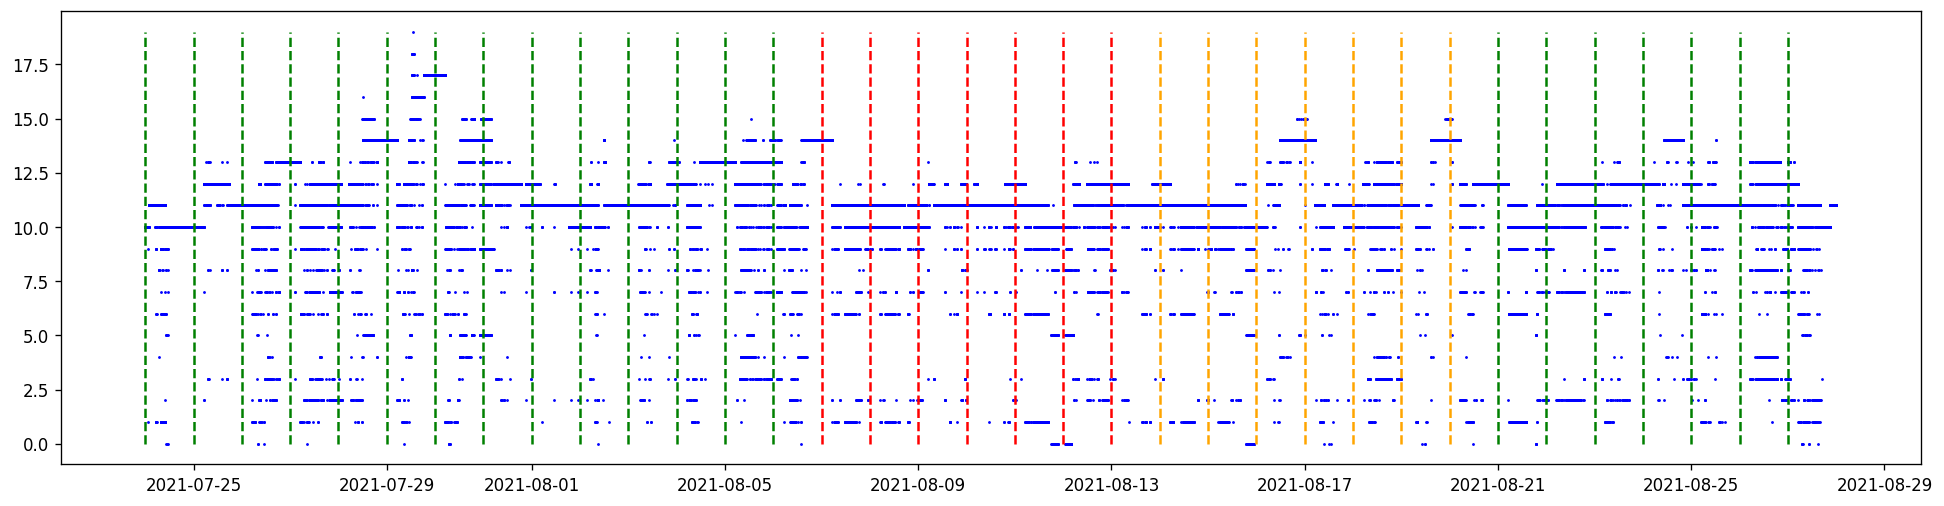

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

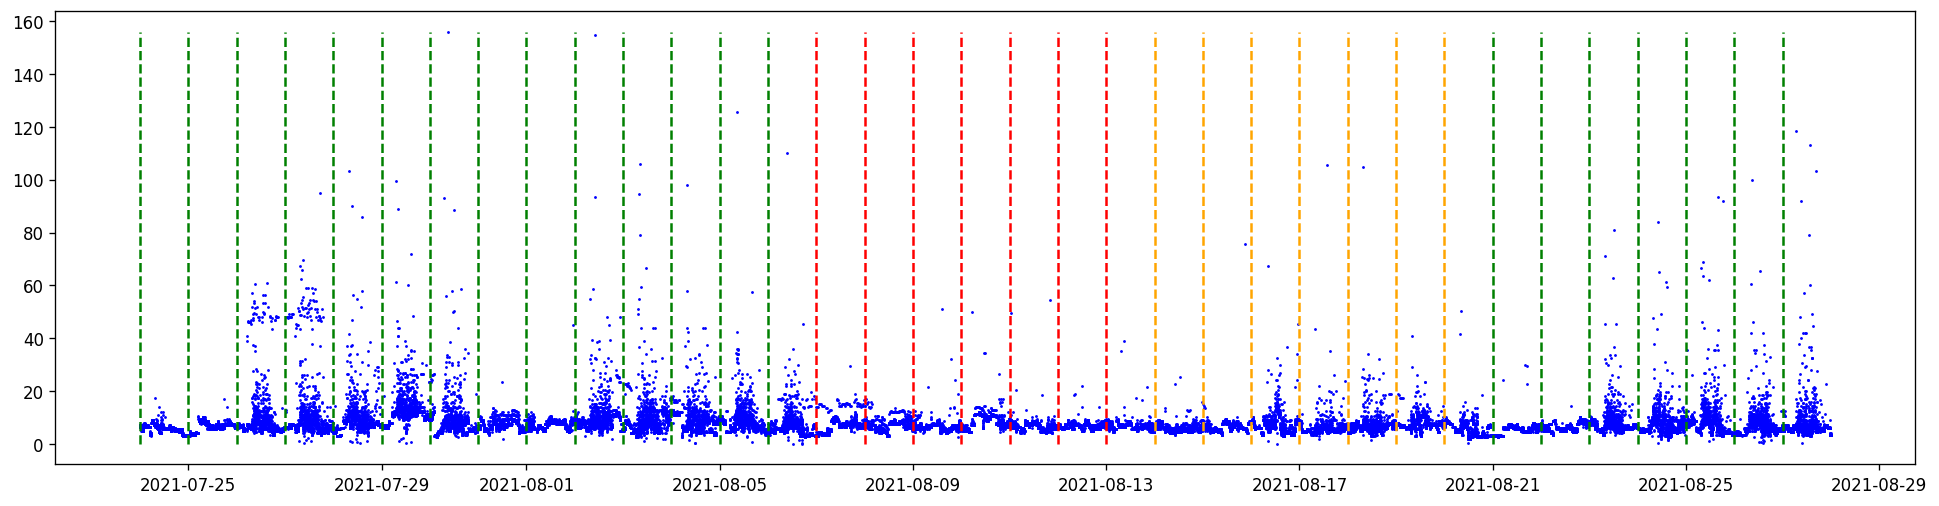

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

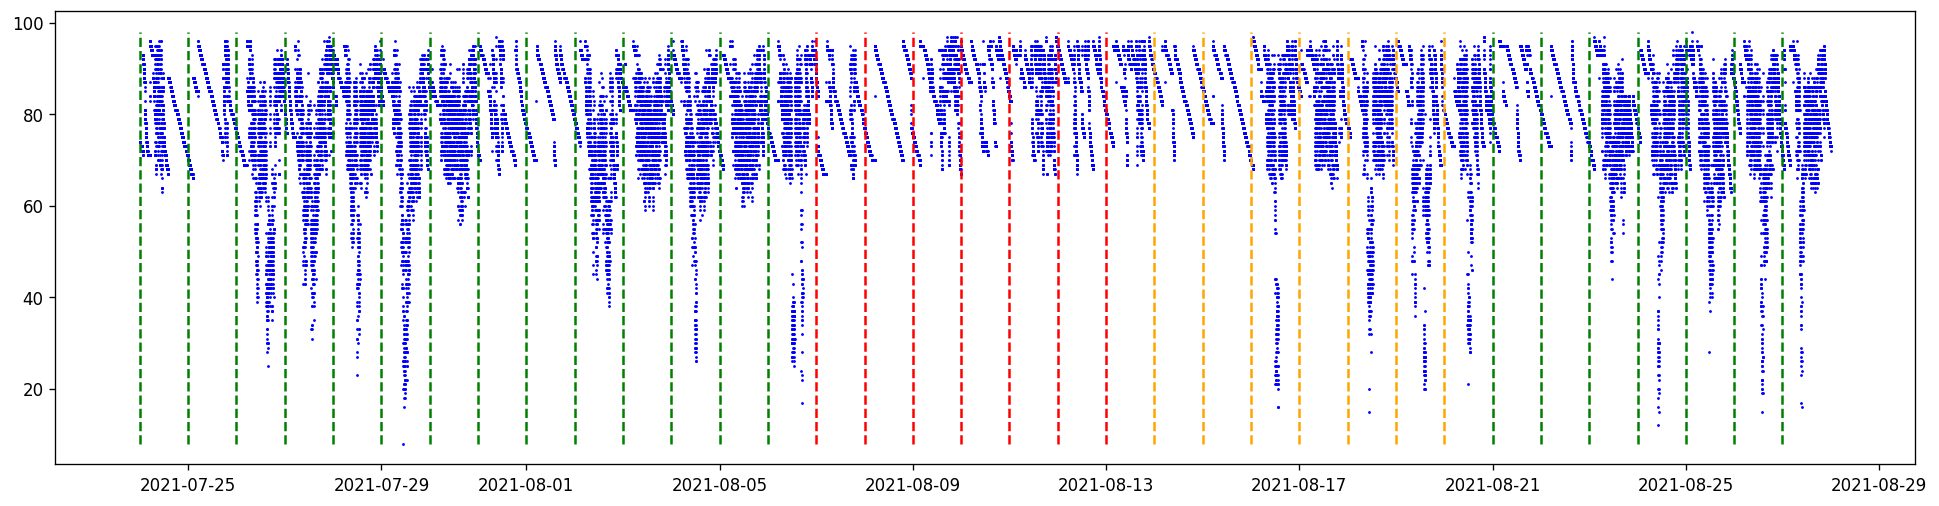

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

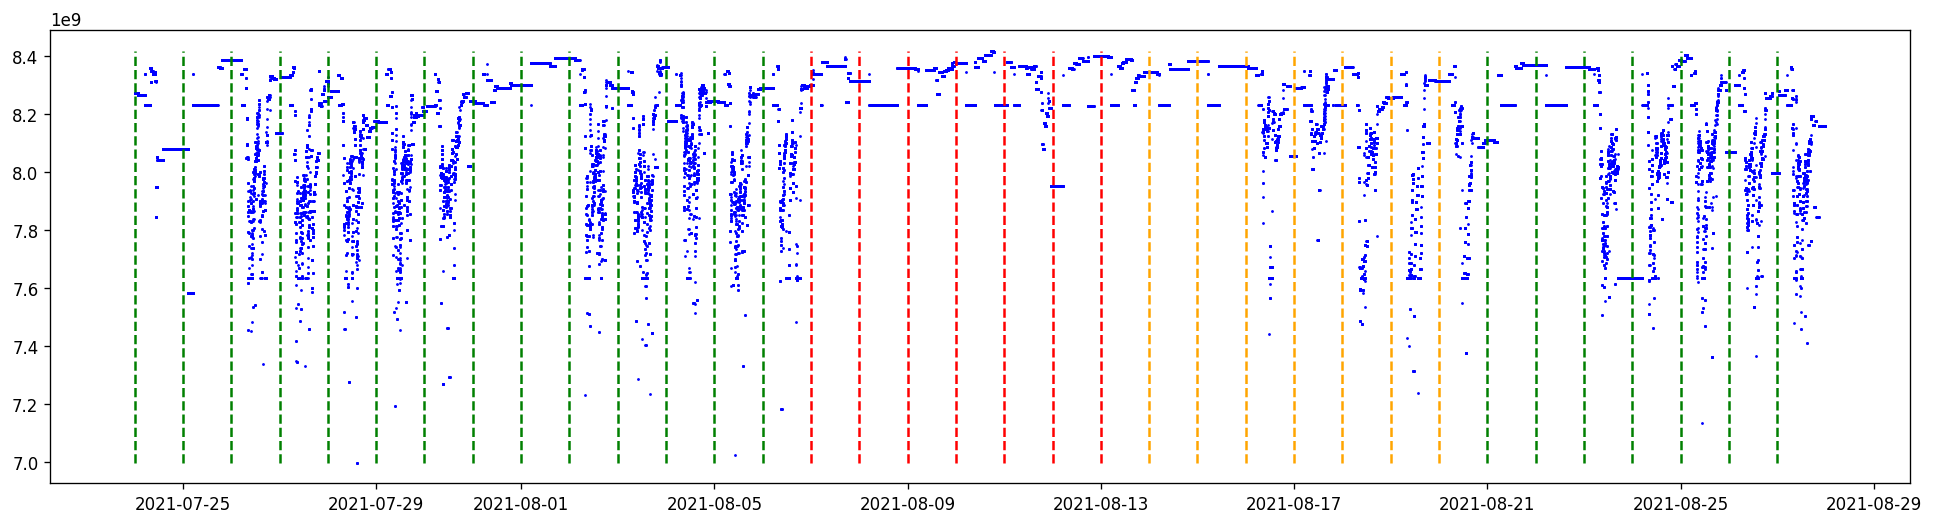

<IPython.core.display.Javascript object>

In [43]:
tb = widgets.TabBar([columns[i] for i in range(len(columns))])

midnights = np.array([])
colors=np.array([])
count=0
for i in range(0,len(df.index),period_length):
  midnights=np.append(midnights,df.index[i])
  if count <14 or count >=28:
    colors=np.append(colors,'green')
  else:
    if count >= 14 and count <21:
      colors=np.append(colors,'red')
    else :
      colors=np.append(colors,'orange')
  count=count+1


for col in columns:
  with tb.output_to(col):
    plt.rcParams.update({'figure.figsize': (25, 10), 'figure.dpi': 120})
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.scatter(x=df.index, y=df[col], color='blue',s=0.5)
    ax.vlines(midnights, df[col].min(), df[col].max(), linestyles='dashed', colors=colors)


    fig.show();

In [44]:
first_two_weeks=df.loc['2021-07-24 00:00:00':'2021-08-06 23:59:00']
last_week=df.loc['2021-08-21 00:00:00': '2021-08-27 23:59:00']
strange_week=df.loc['2021-08-14 00:00:00': '2021-08-20 23:59:00']
remove_week=df.loc['2021-08-07 00:00:00':'2021-08-13 23:59:00']

In [45]:
strange_week=strange_week*1
last_week.index=strange_week.index
strange_week.index=remove_week.index

In [46]:
df=pd.concat([first_two_weeks, strange_week,last_week])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

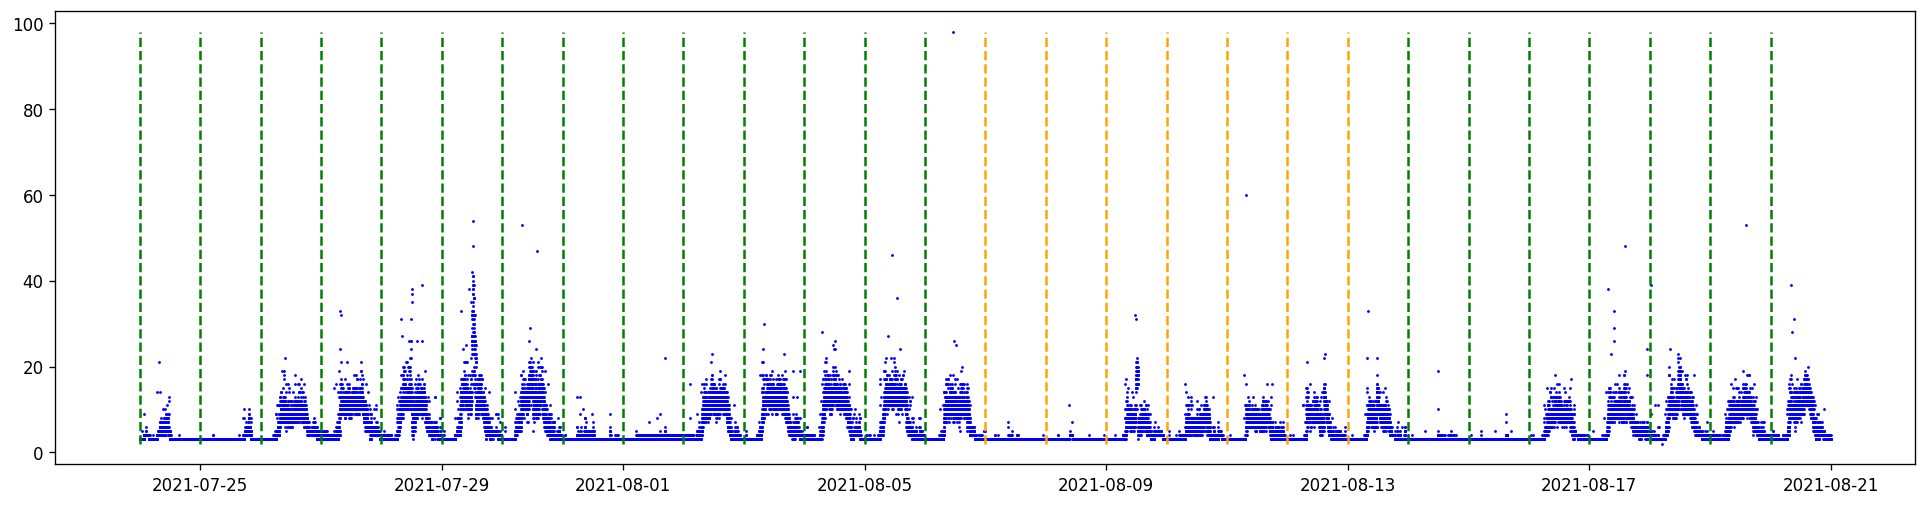

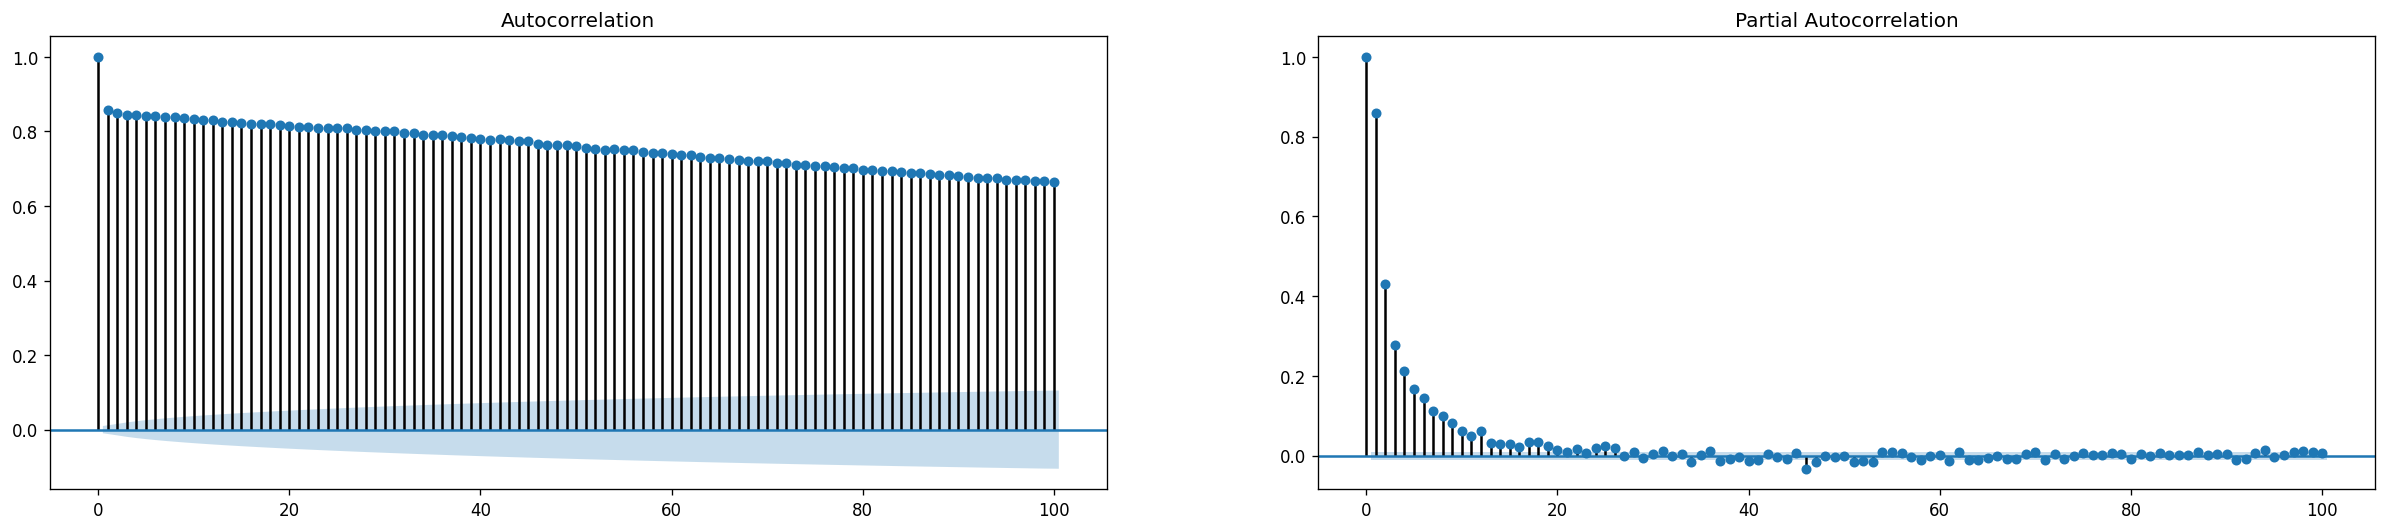

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

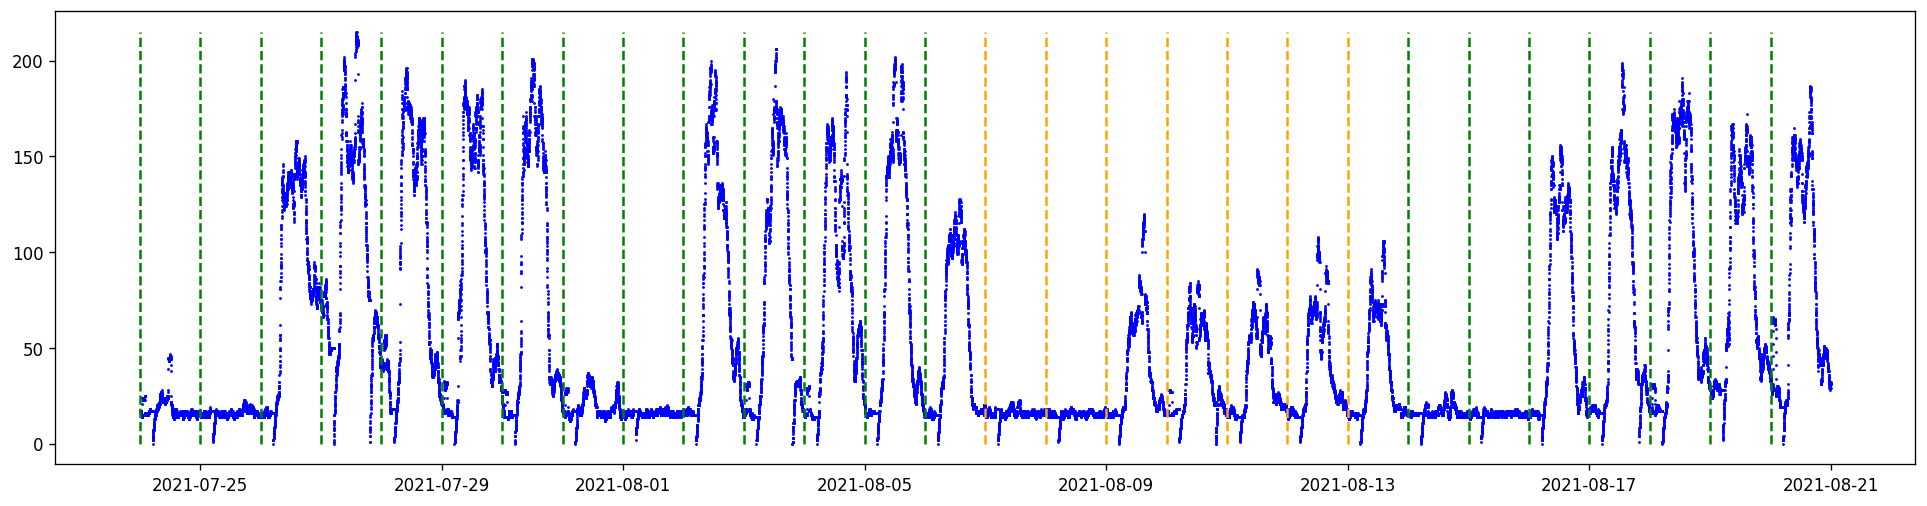

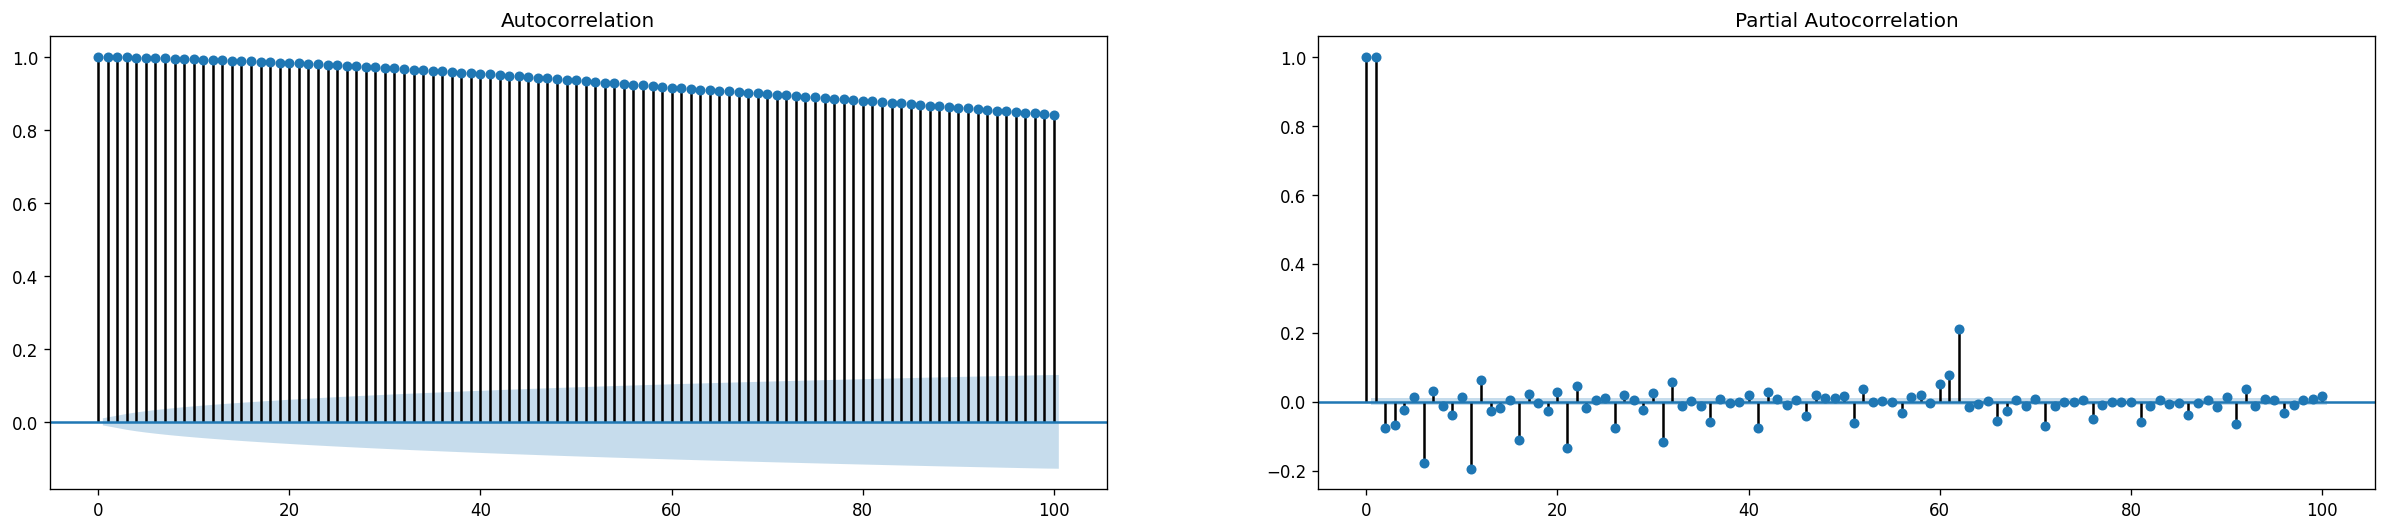

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

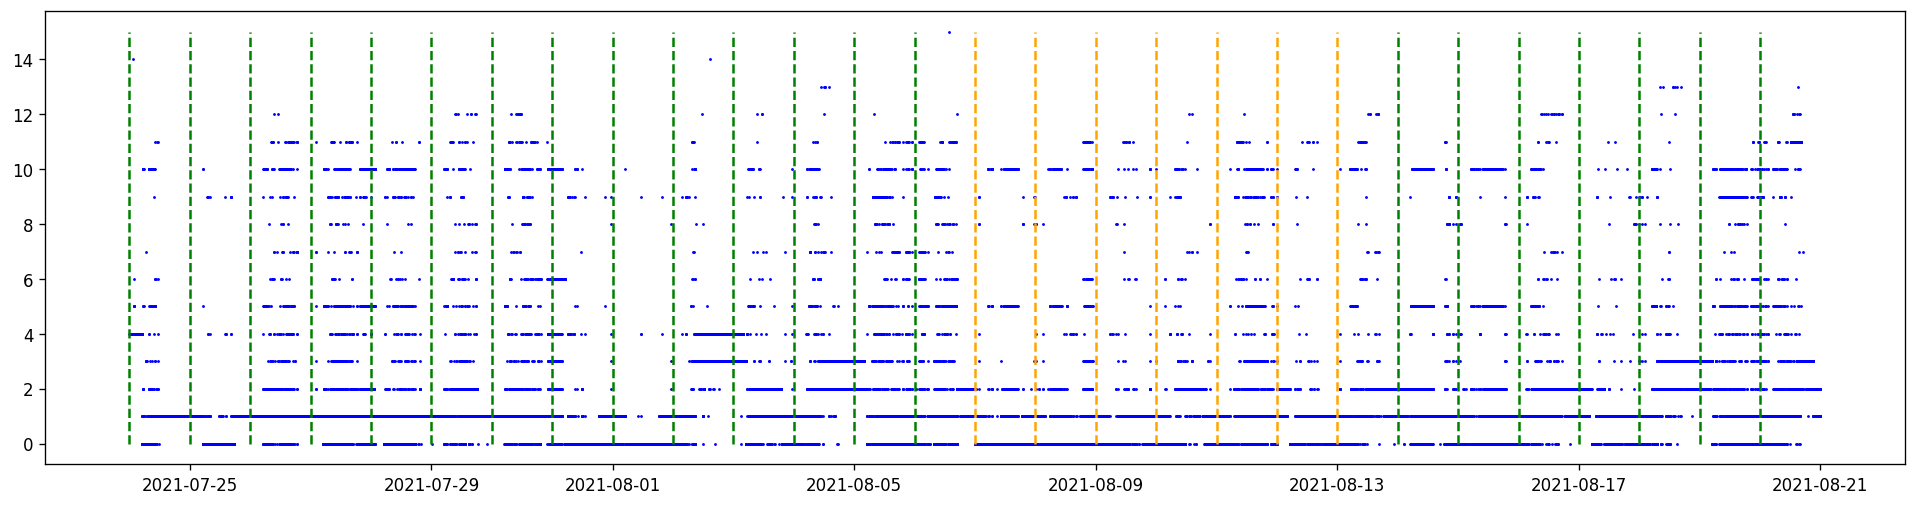

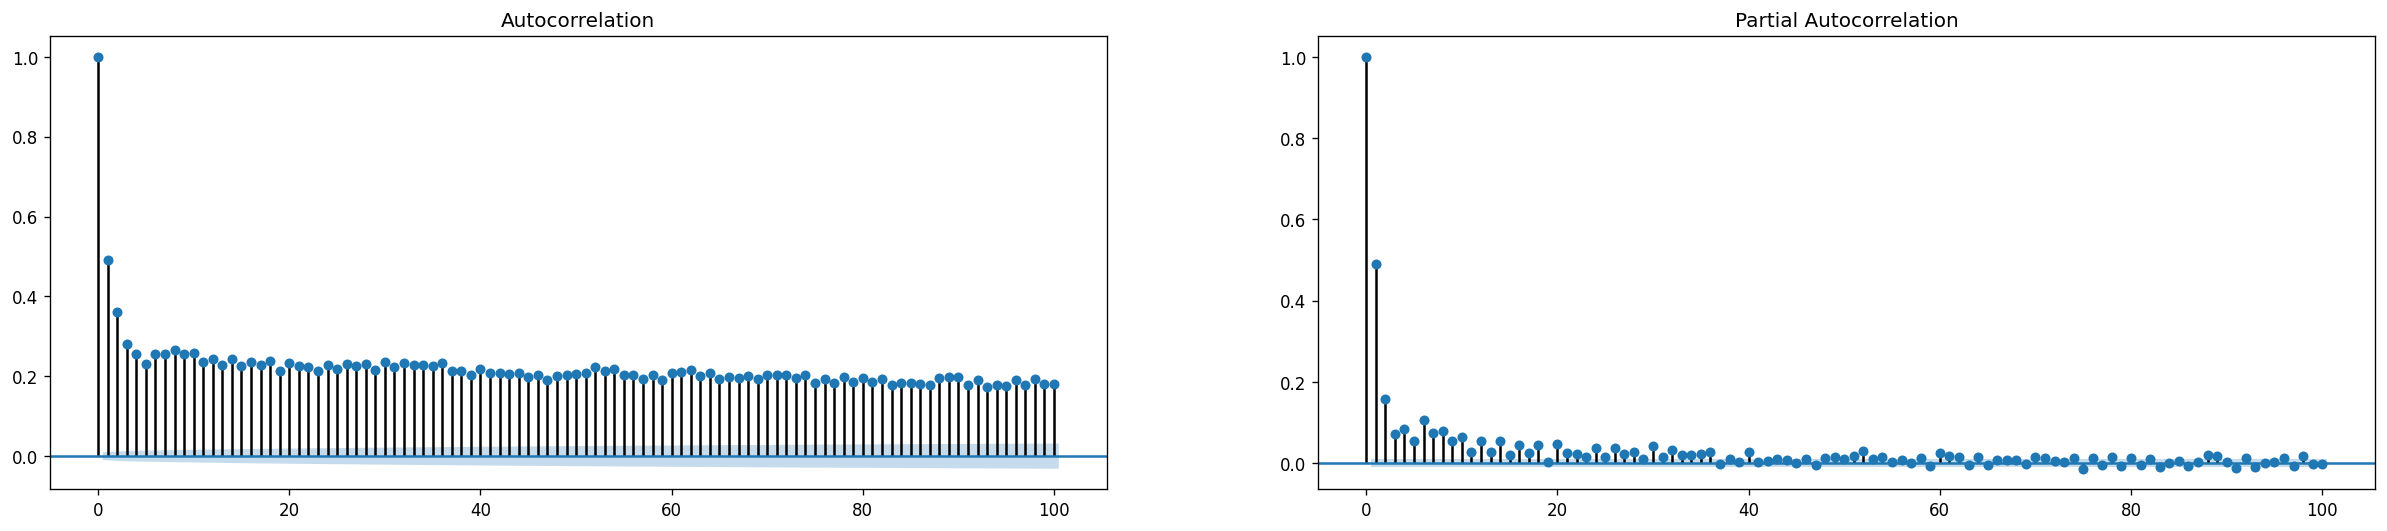

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

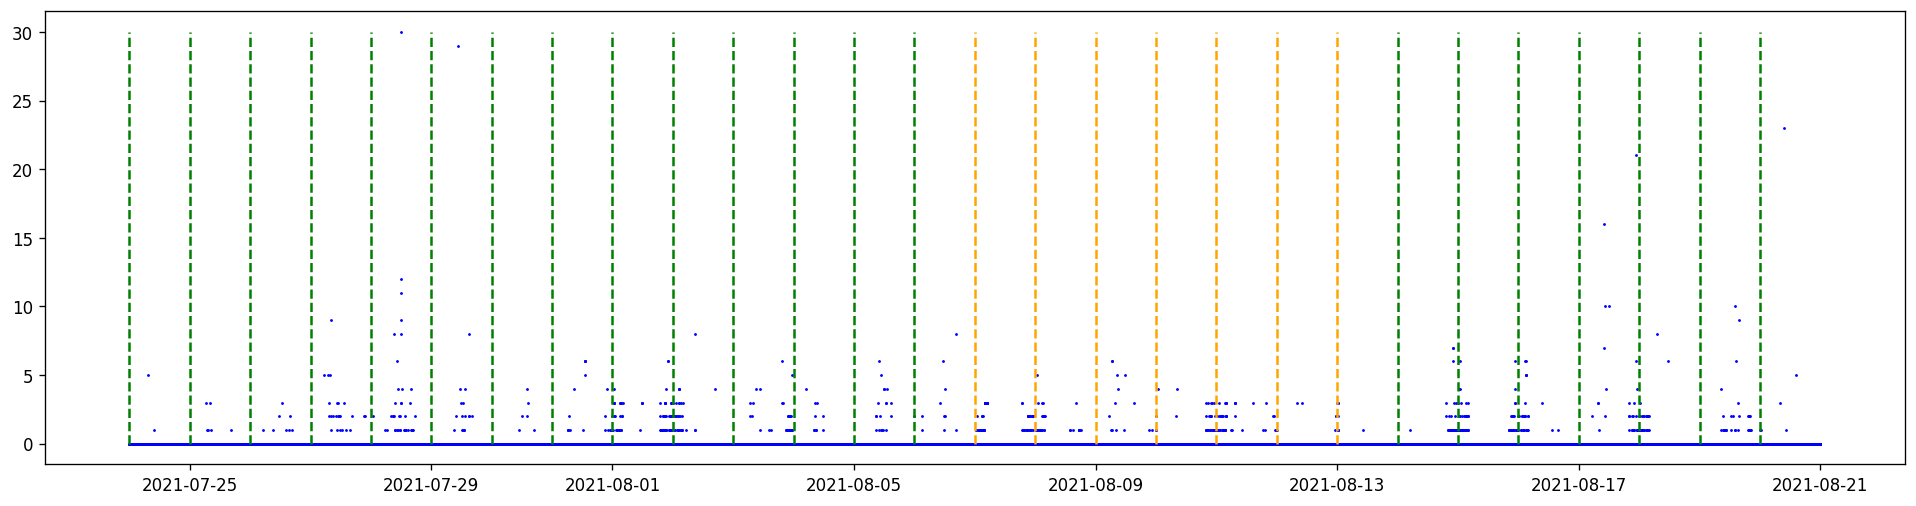

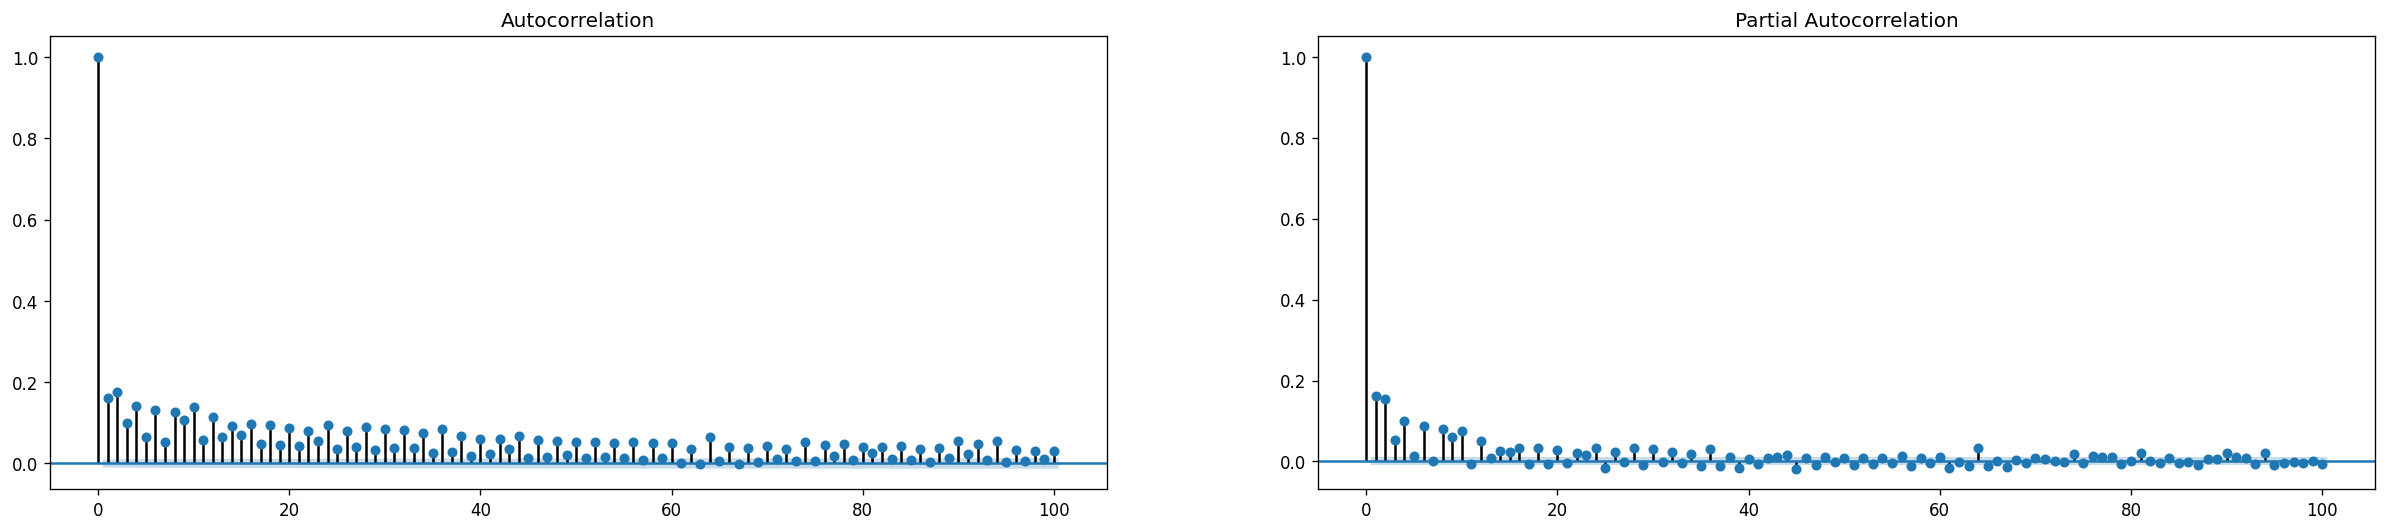

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

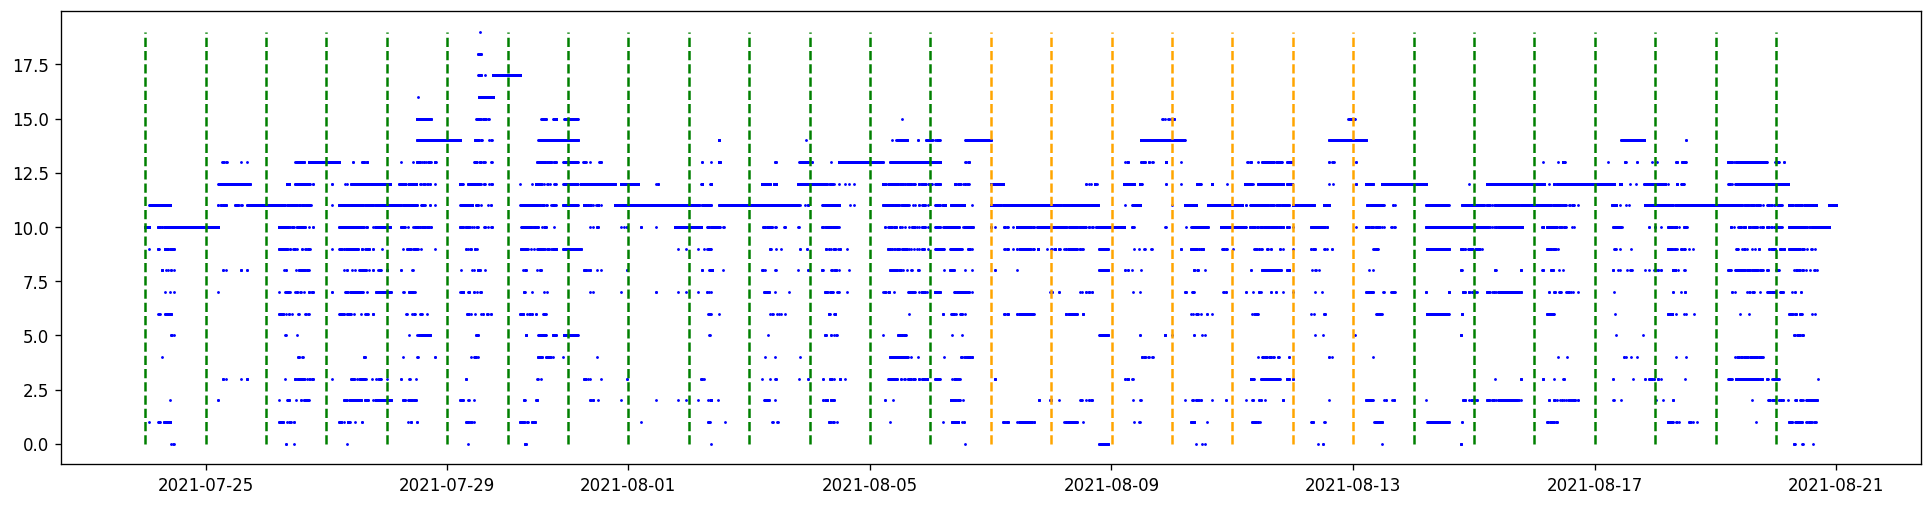

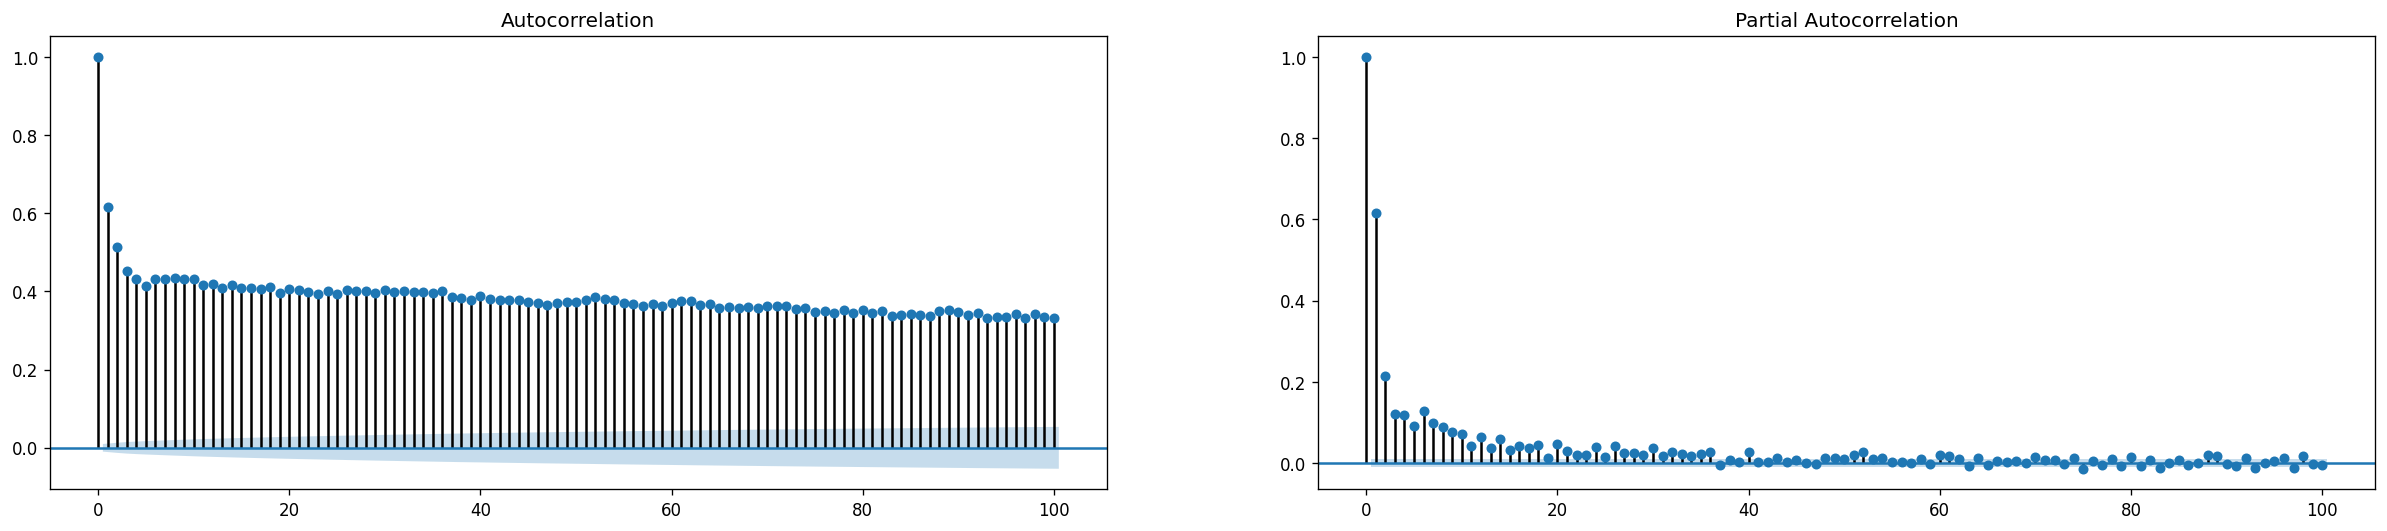

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

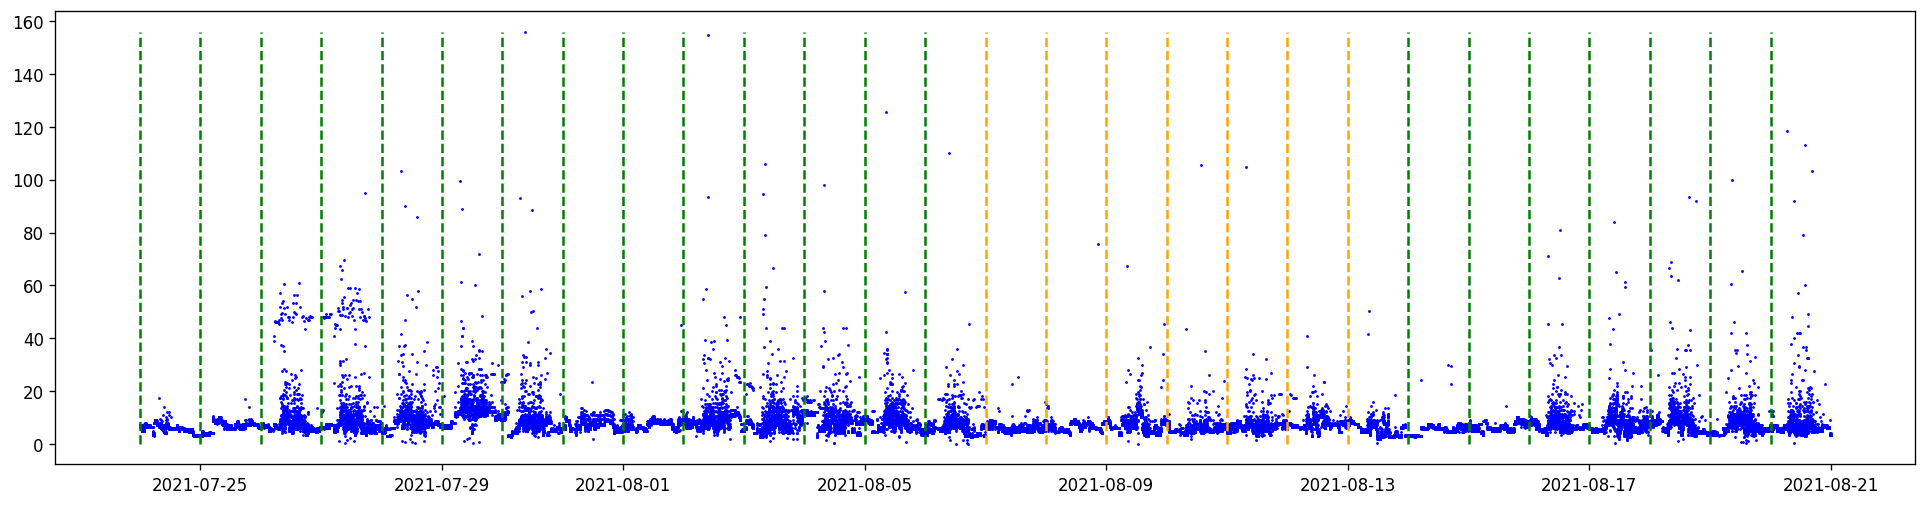

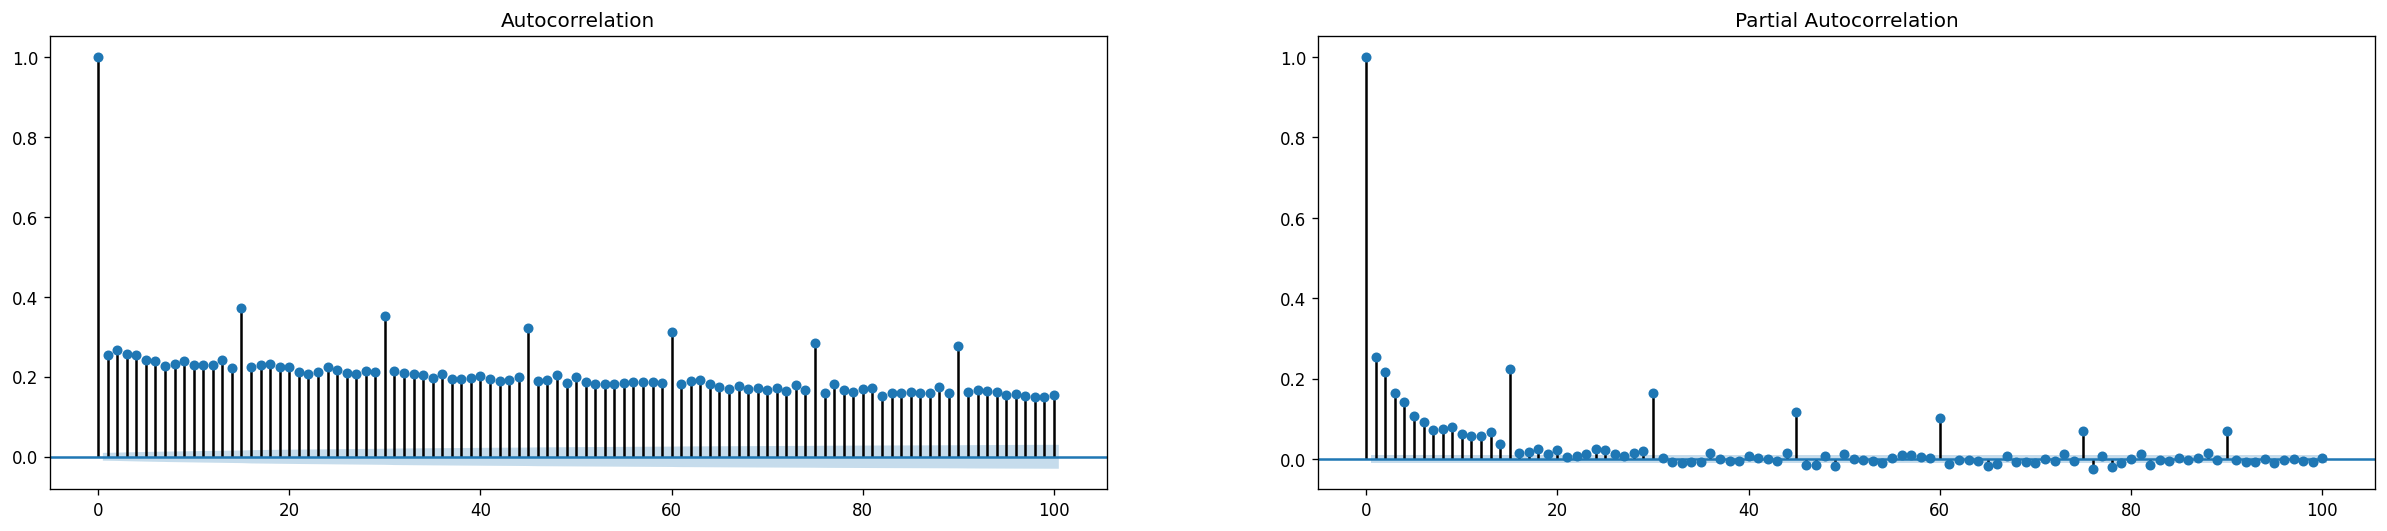

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

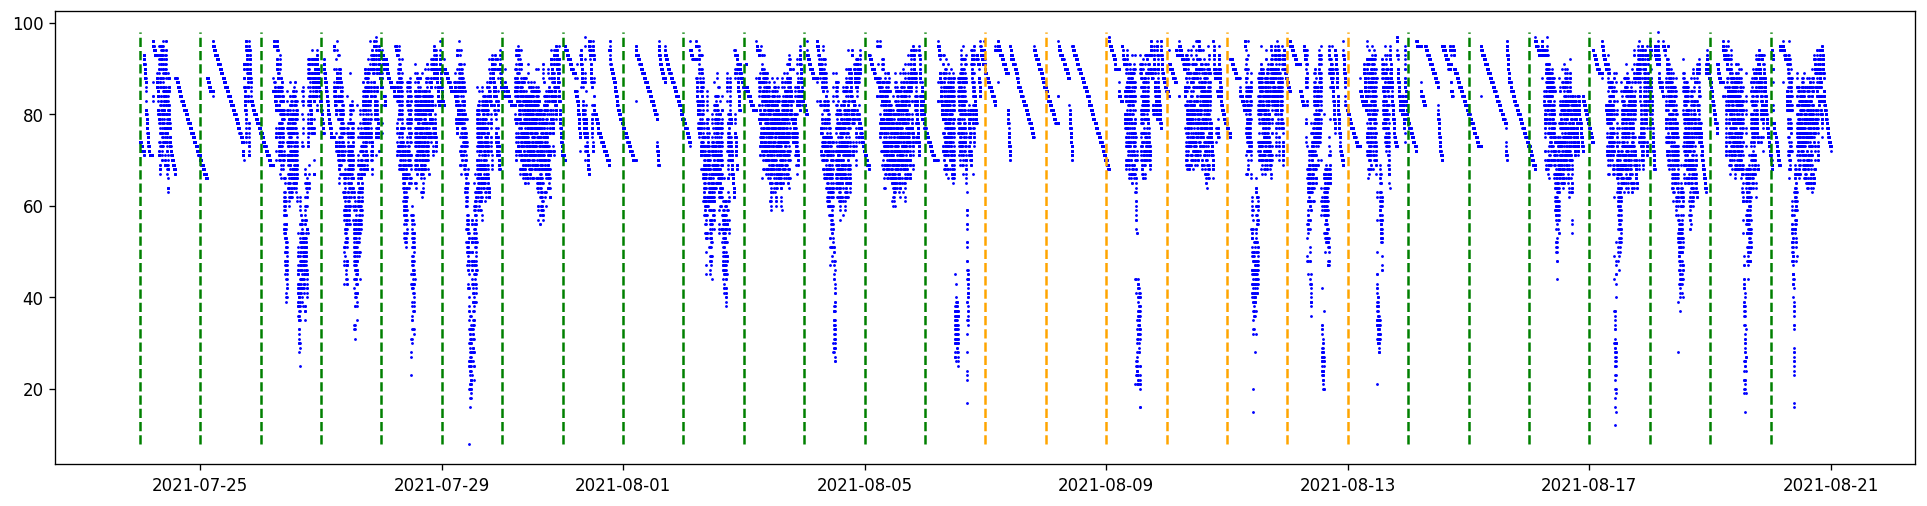

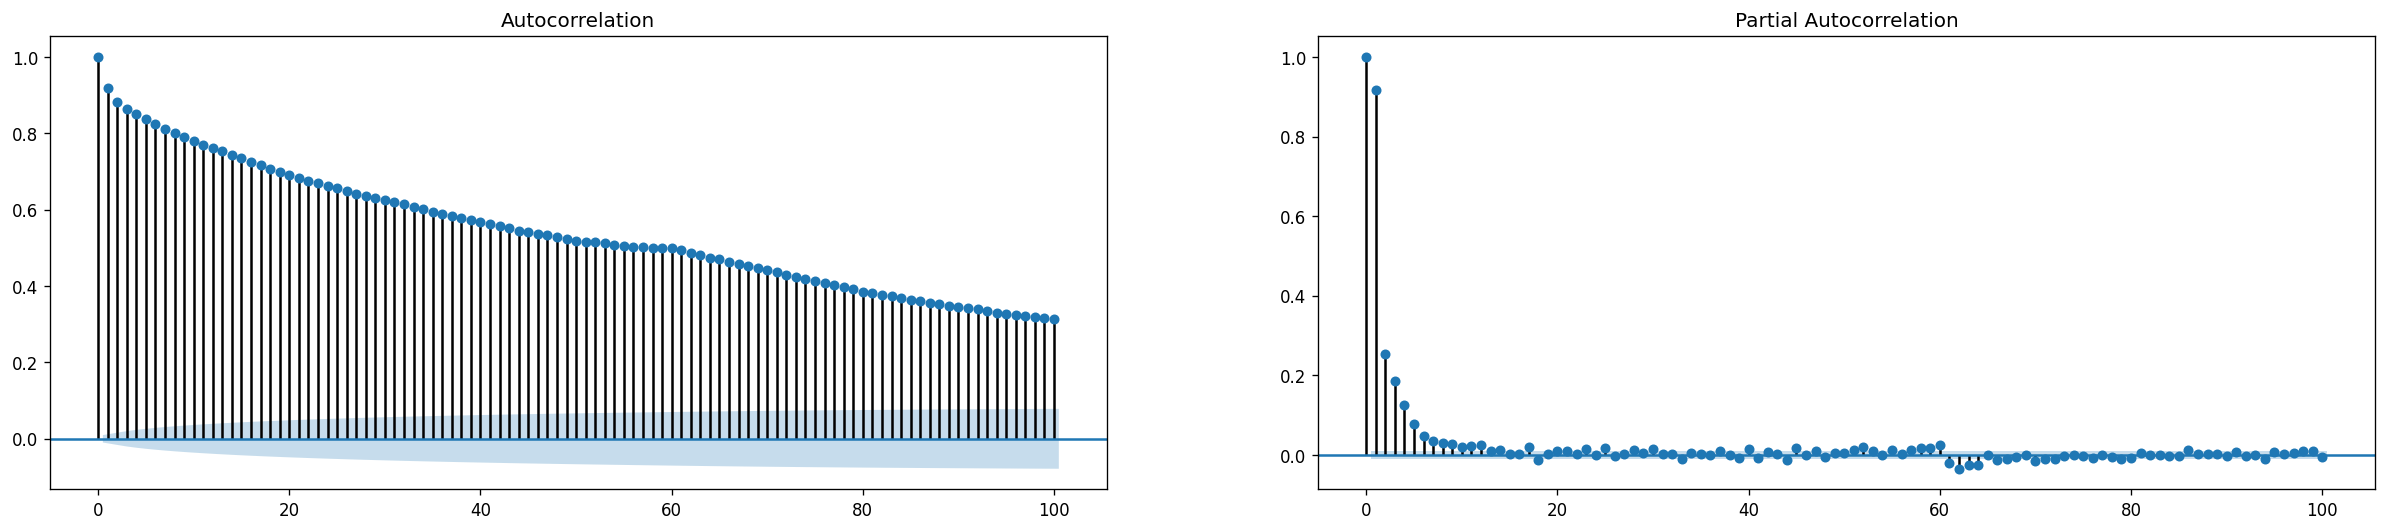

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

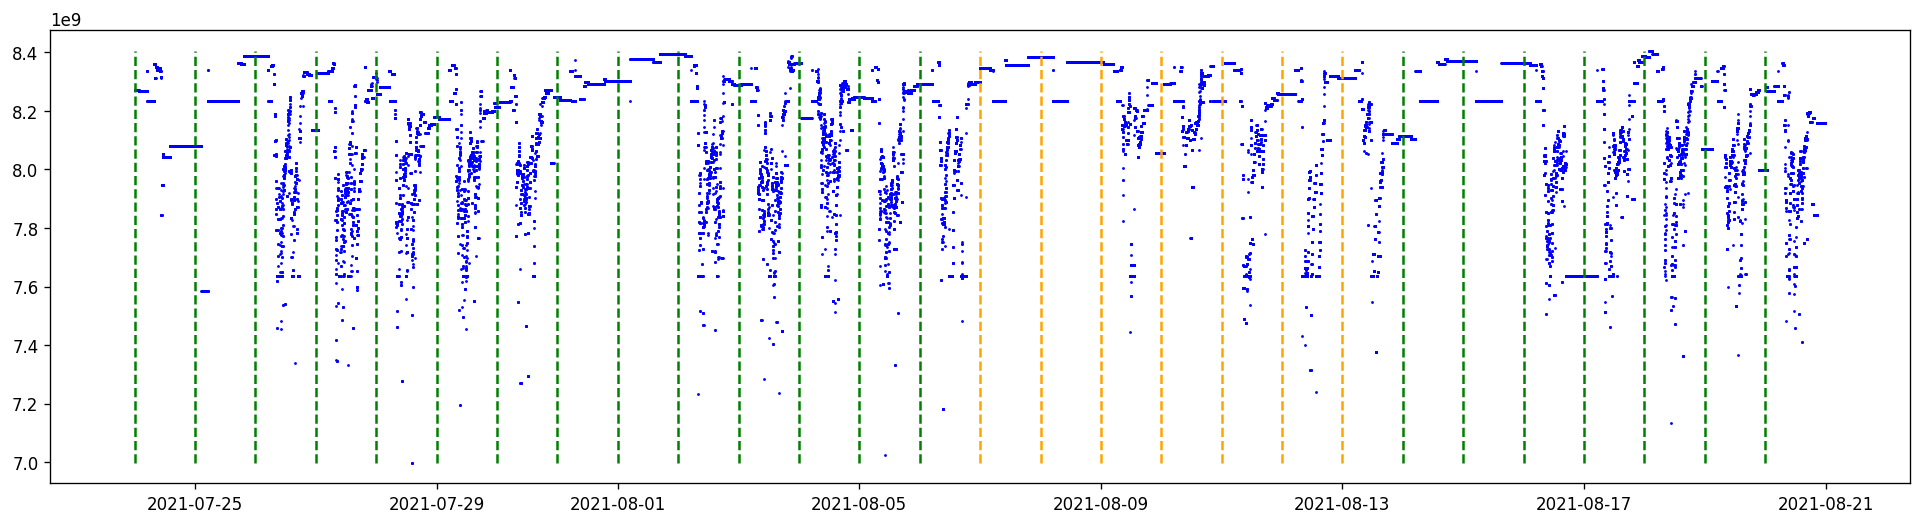

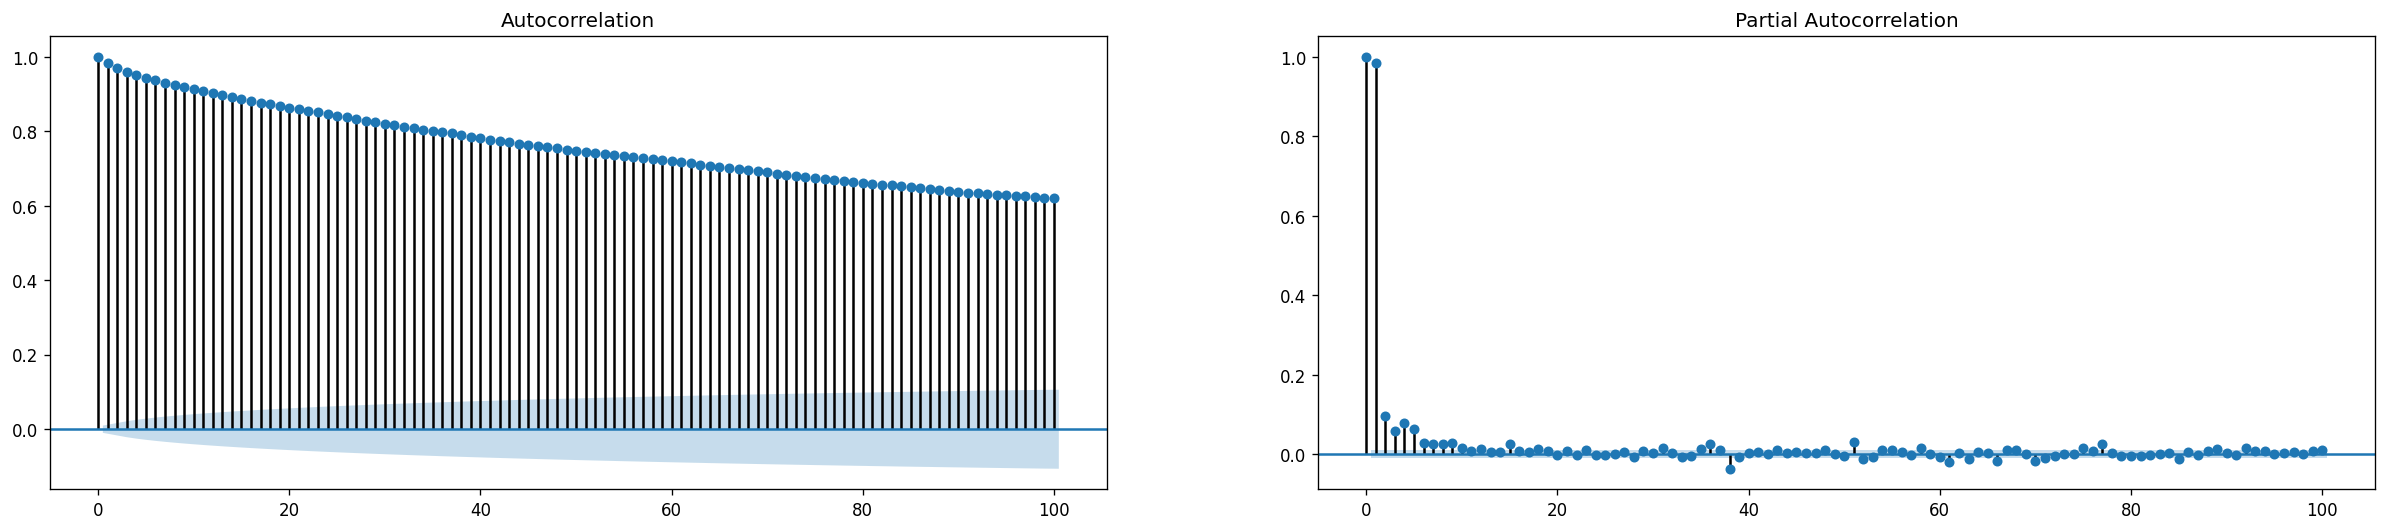

<IPython.core.display.Javascript object>

In [47]:
tb = widgets.TabBar([columns[i] for i in range(len(columns))])

midnights = np.array([])
colors=np.array([])
count=0
for i in range(0,len(df.index),period_length):
  midnights=np.append(midnights,df.index[i])
  if count <14 or count >=28:
    colors=np.append(colors,'green')
  else:
    if count >= 14 and count <21:
      colors=np.append(colors,'orange')
  count=count+1


for col in columns:
  with tb.output_to(col):
    plt.rcParams.update({'figure.figsize': (25, 10), 'figure.dpi': 120})
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.scatter(x=df.index, y=df[col], color='blue',s=0.5)
    ax.vlines(midnights, df[col].min(), df[col].max(), linestyles='dashed', colors=colors)
    fig.show();
    fig, ax = plt.subplots(1,2,figsize= (25, 5))
    plot_acf(df[col], lags =100, ax=ax[0])
    plot_pacf(df[col], lags =100,ax=ax[1])
    plt.show();


**PROPHET**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

07-29 12:17
0.5516666666666666
0.030000000000000002
07-30 07:51
0.5412499999999999
0
08-06 11:13
1.0099999999999998
0
08-11 07:30
0.6141666666666666
-0.05
08-19 14:09
0.5412499999999999
0.030000000000000002


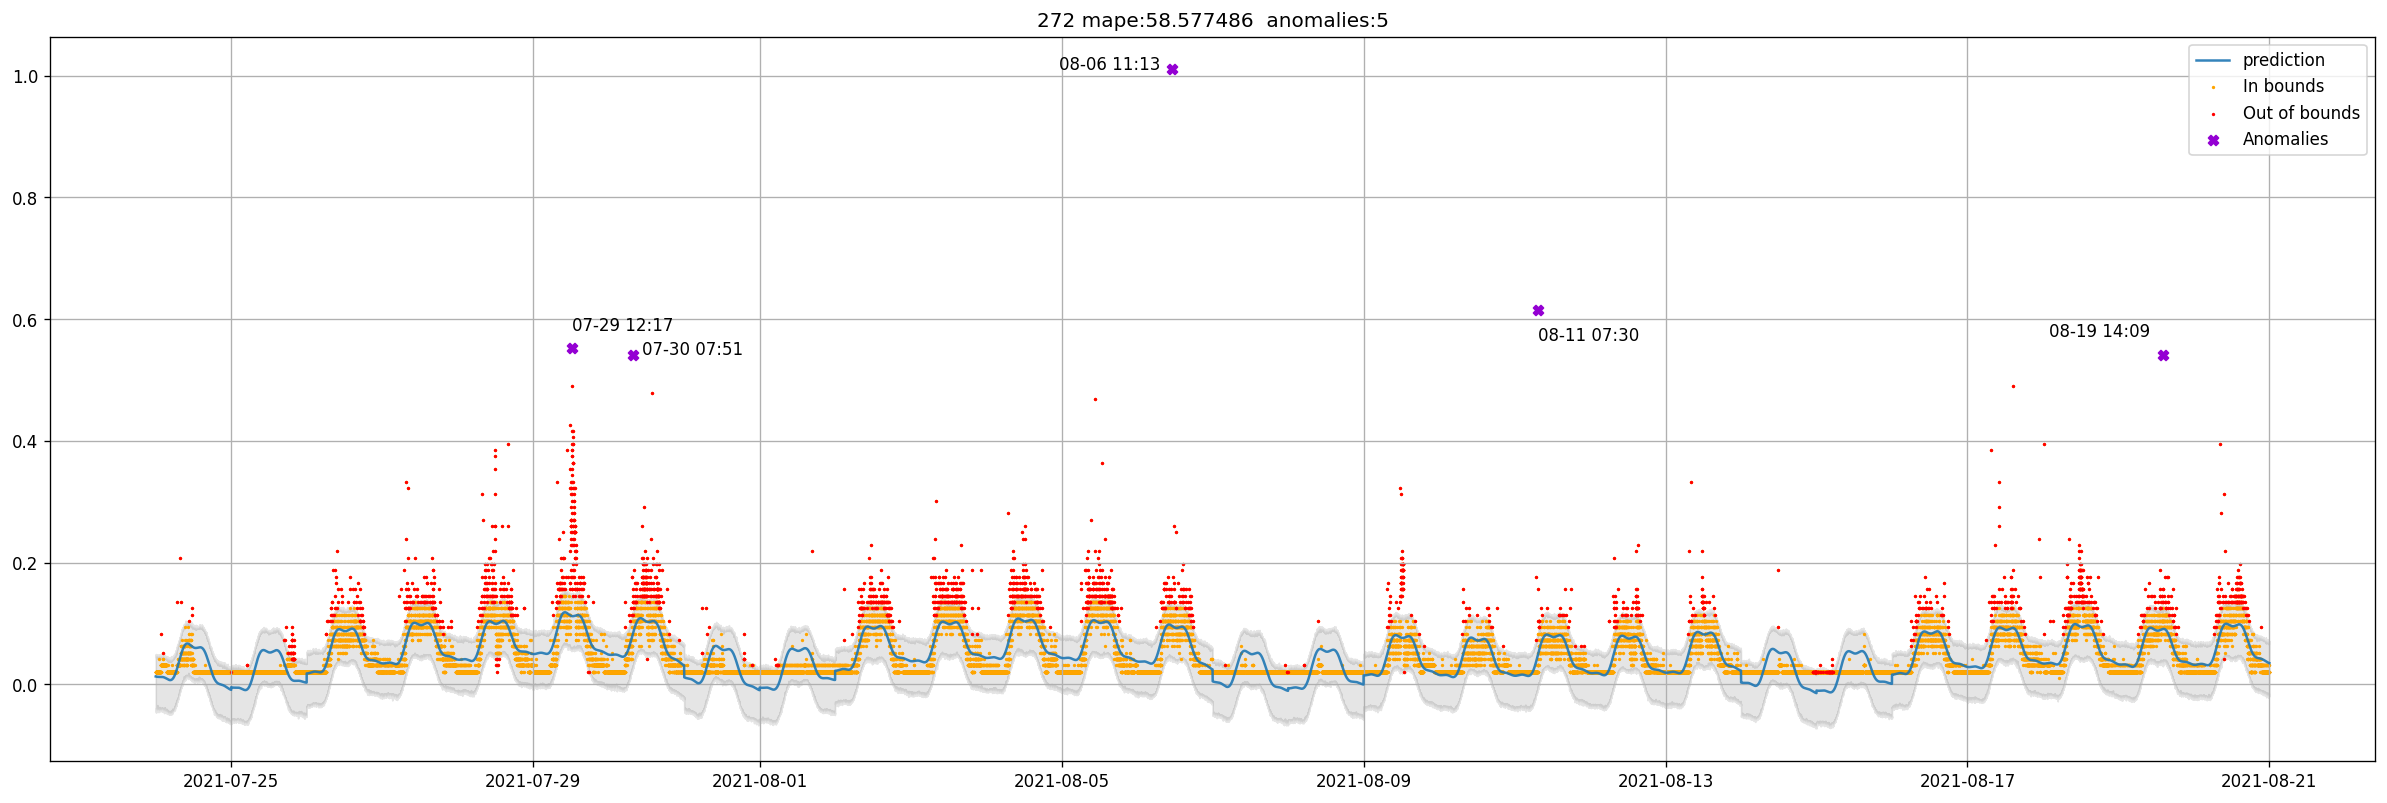

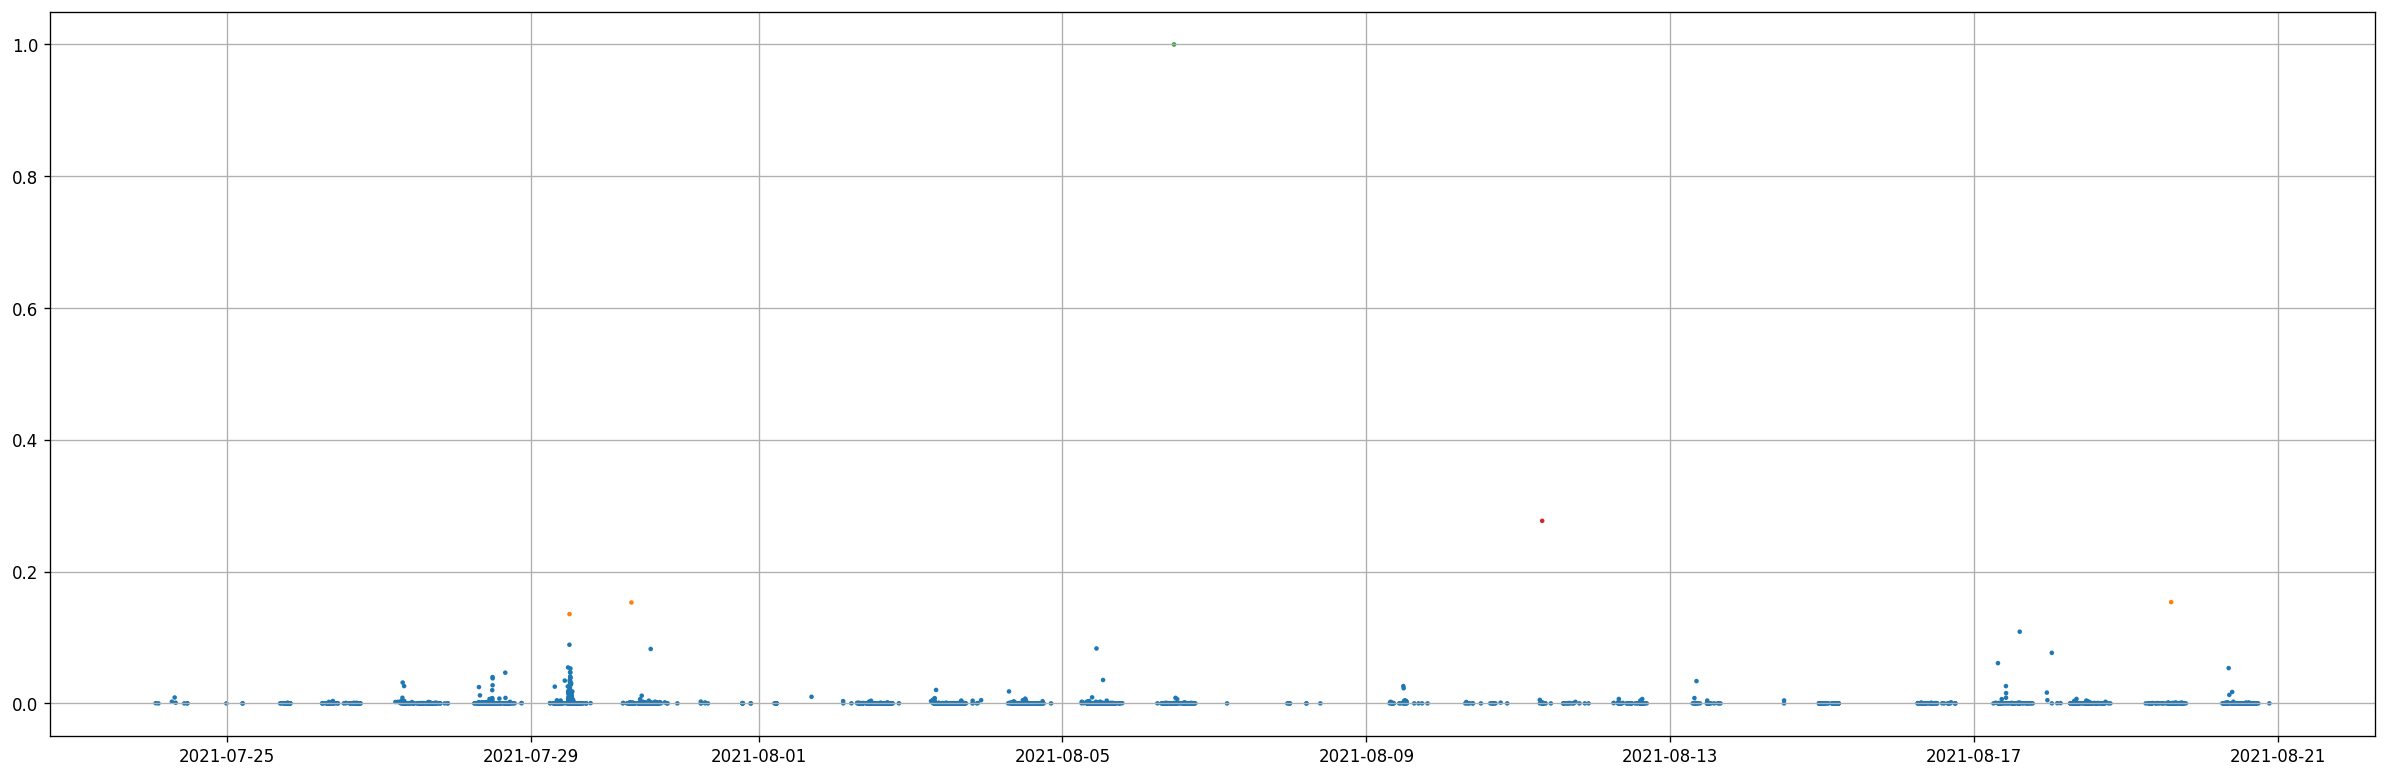

272 execution time :135.62424874305725 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

07-30 12:32
0.9355813953488372
-0.05
08-02 12:46
0.9169767441860465
0.030000000000000002
08-03 12:40
0.9541860465116279
0
08-03 12:42
0.968139534883721
0
08-03 12:43
0.968139534883721
-0.05
08-03 12:44
0.968139534883721
0.030000000000000002
08-03 12:45
0.968139534883721
-0.05
08-03 12:46
0.968139534883721
0.030000000000000002
08-04 16:40
0.8937209302325582
0
08-04 16:43
0.8983720930232558
0
08-04 16:44
0.9030232558139535
-0.05
08-04 16:45
0.8983720930232558
0.030000000000000002
08-04 16:46
0.9076744186046511
-0.05
08-04 16:47
0.9123255813953488
0.030000000000000002
08-04 16:48
0.8983720930232558
0
08-05 12:14
0.9402325581395349
0


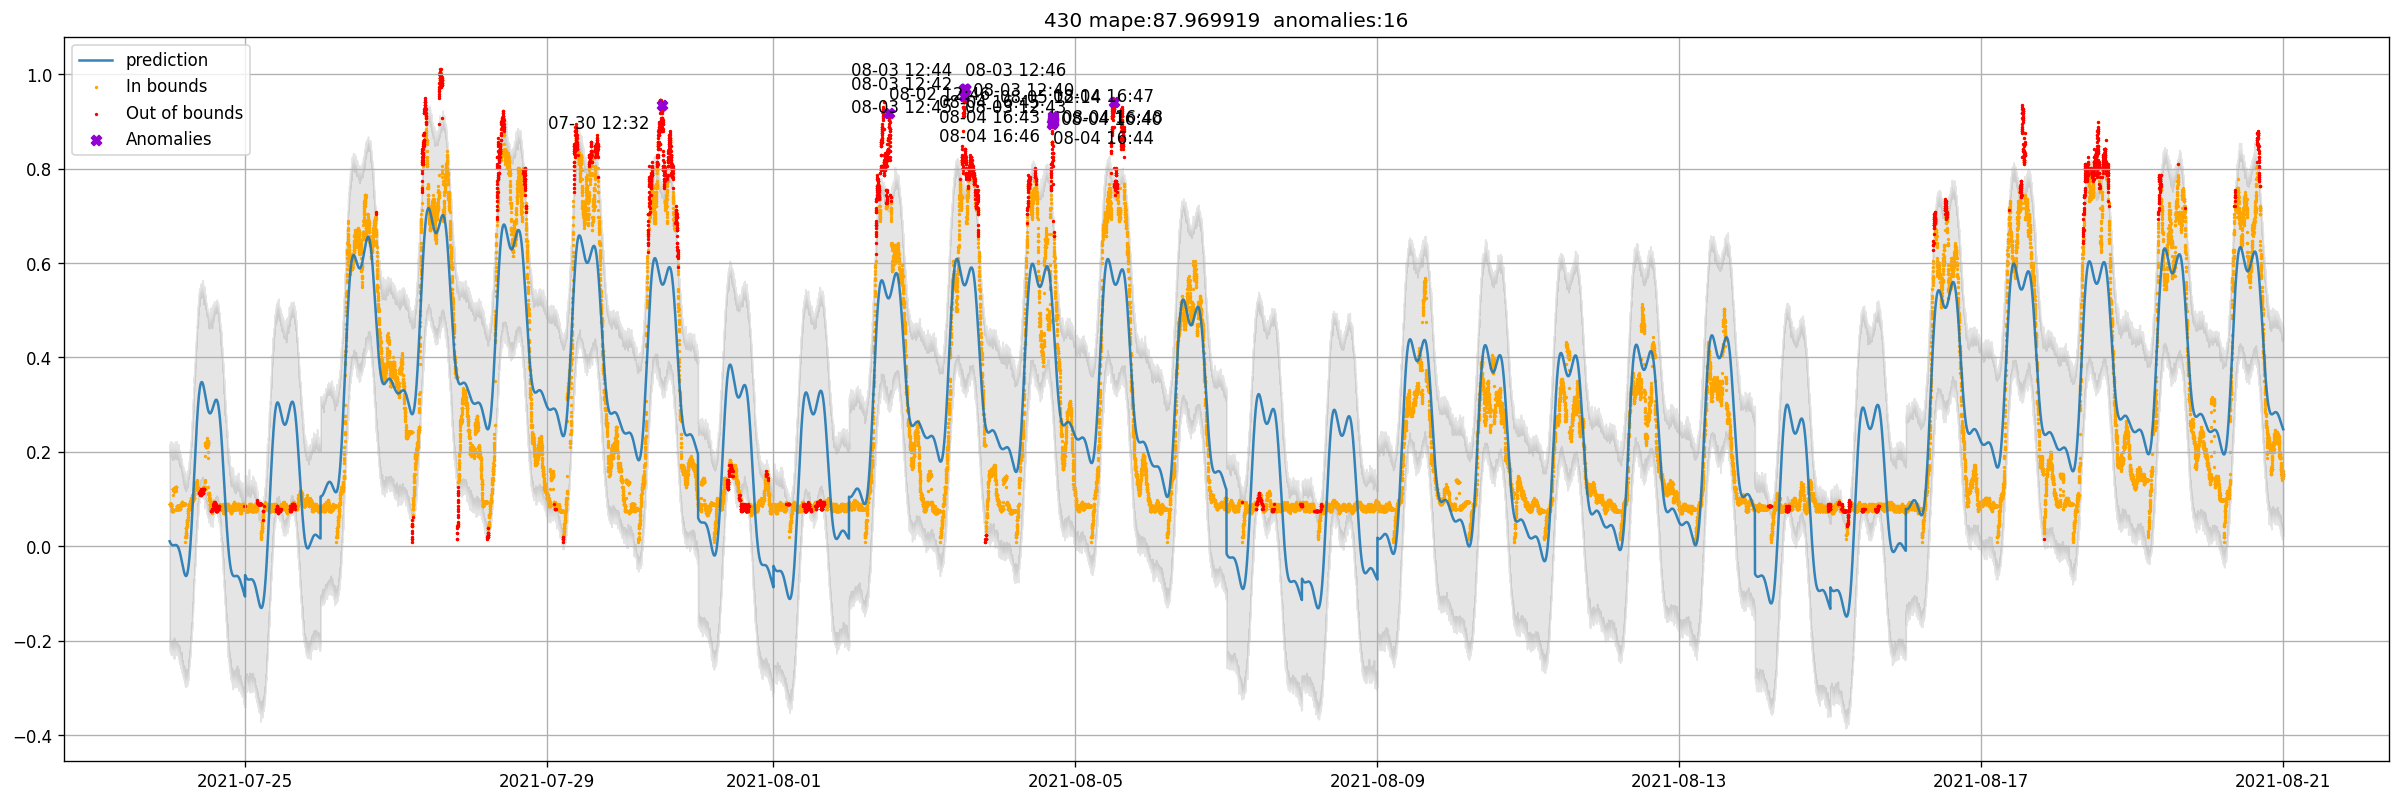

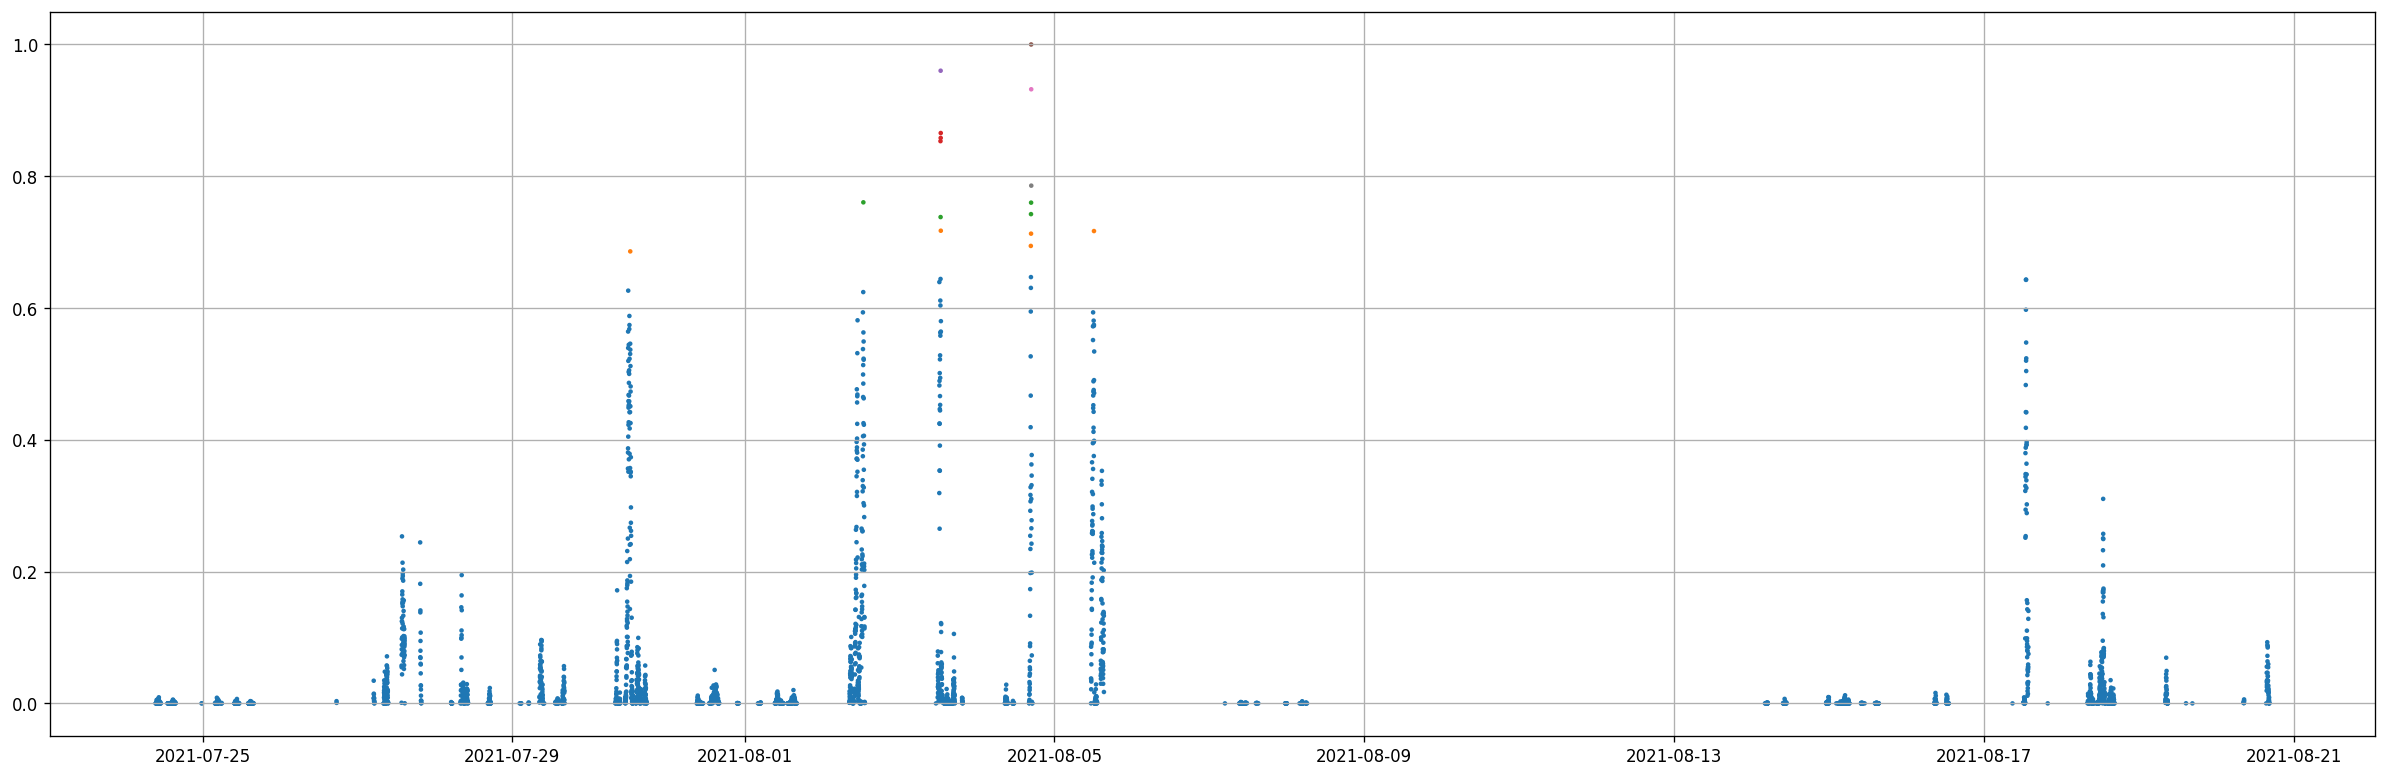

430 execution time :120.18936586380005 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

07-24 01:36
0.9433333333333334
-0.05
08-02 14:31
0.9433333333333334
0.030000000000000002
08-06 13:41
1.01
-0.05
08-10 12:58
0.81
0.030000000000000002
08-18 08:18
0.8766666666666667
0


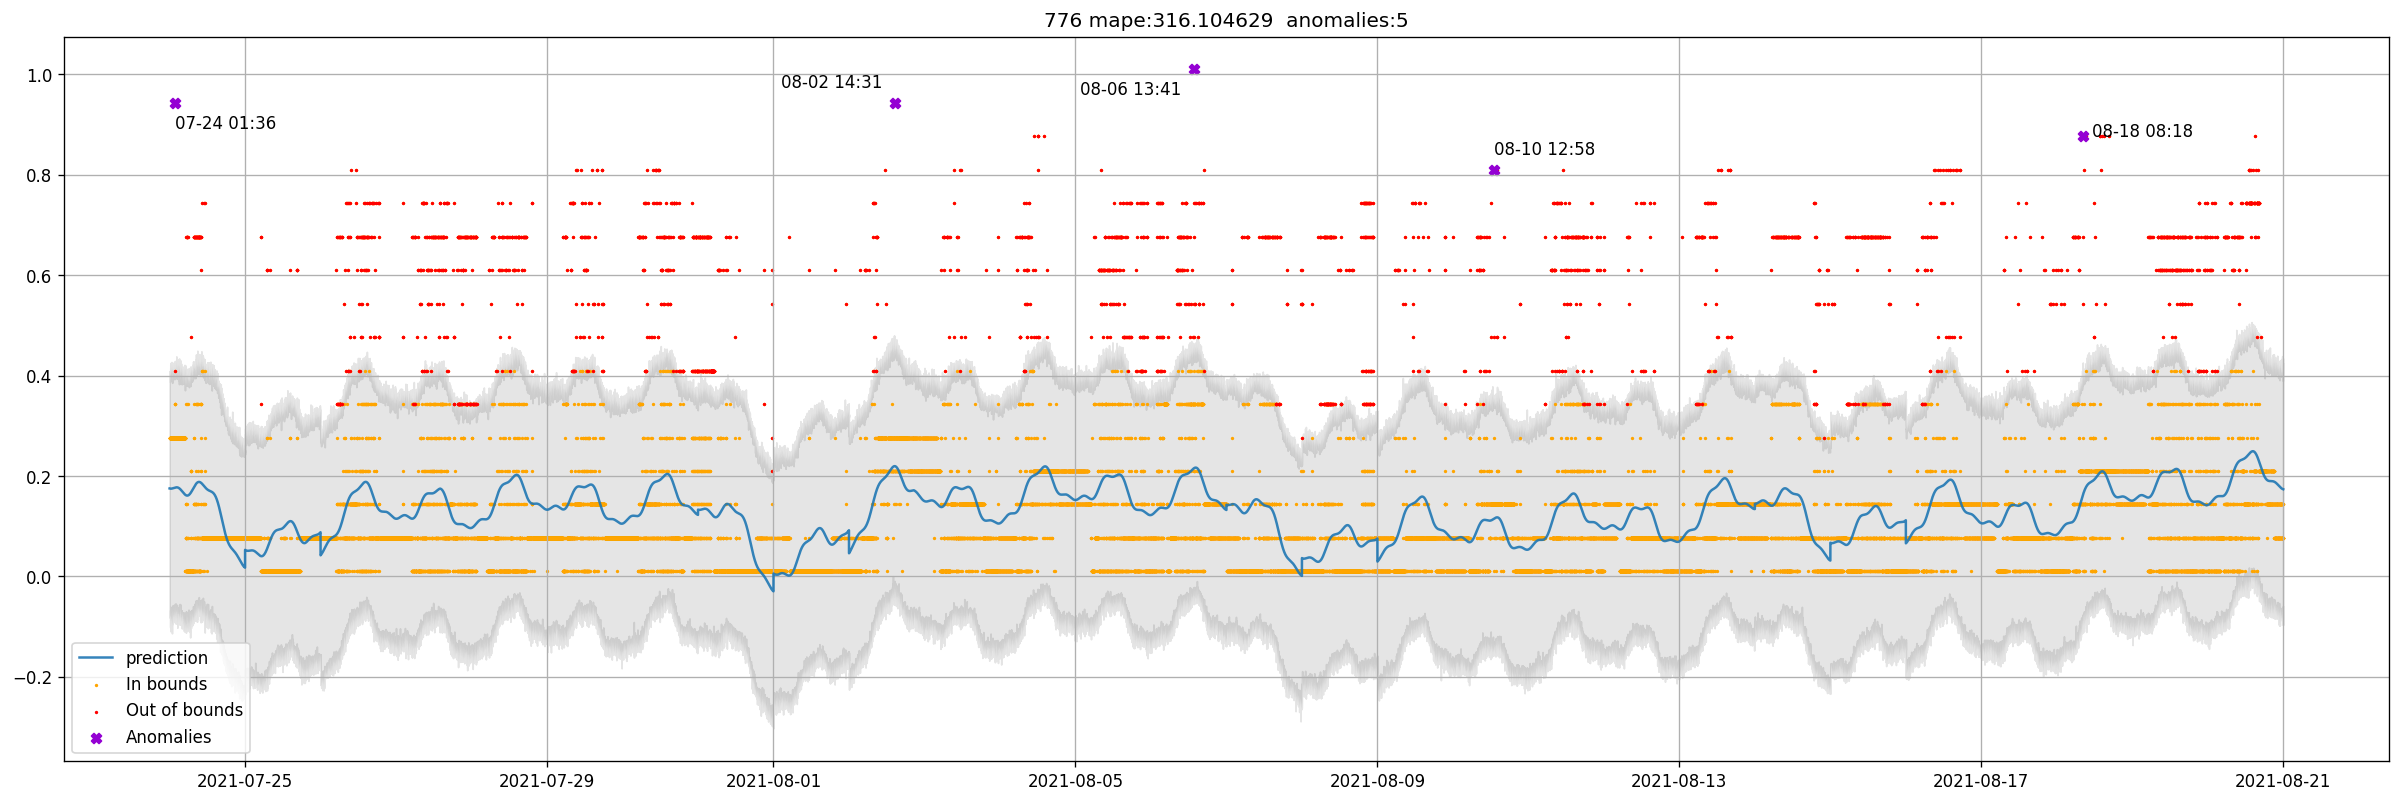

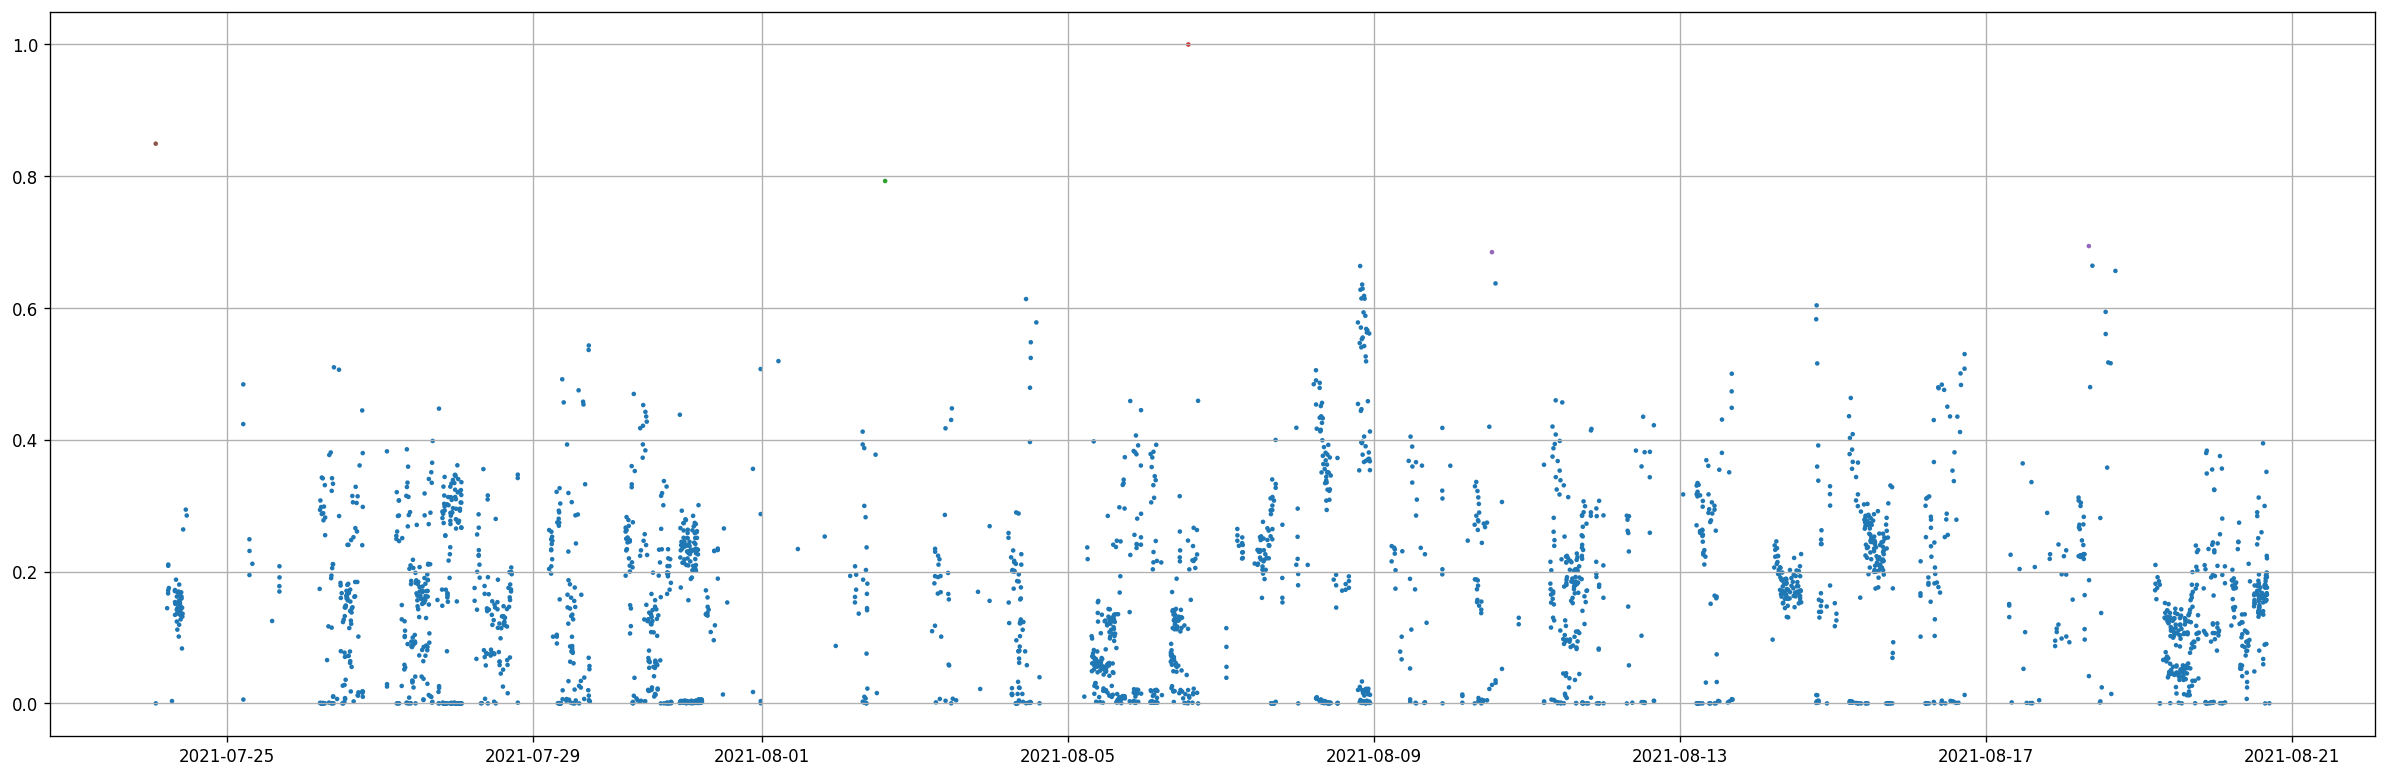

776 execution time :100.44273376464844 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

07-28 11:59
0.41000000000000003
0
07-28 12:00
1.01
-0.05
07-29 10:48
0.9766666666666667
0.030000000000000002
08-17 10:00
0.5433333333333333
-0.05
08-17 22:53
0.71
0.030000000000000002
08-20 09:26
0.7766666666666666
0


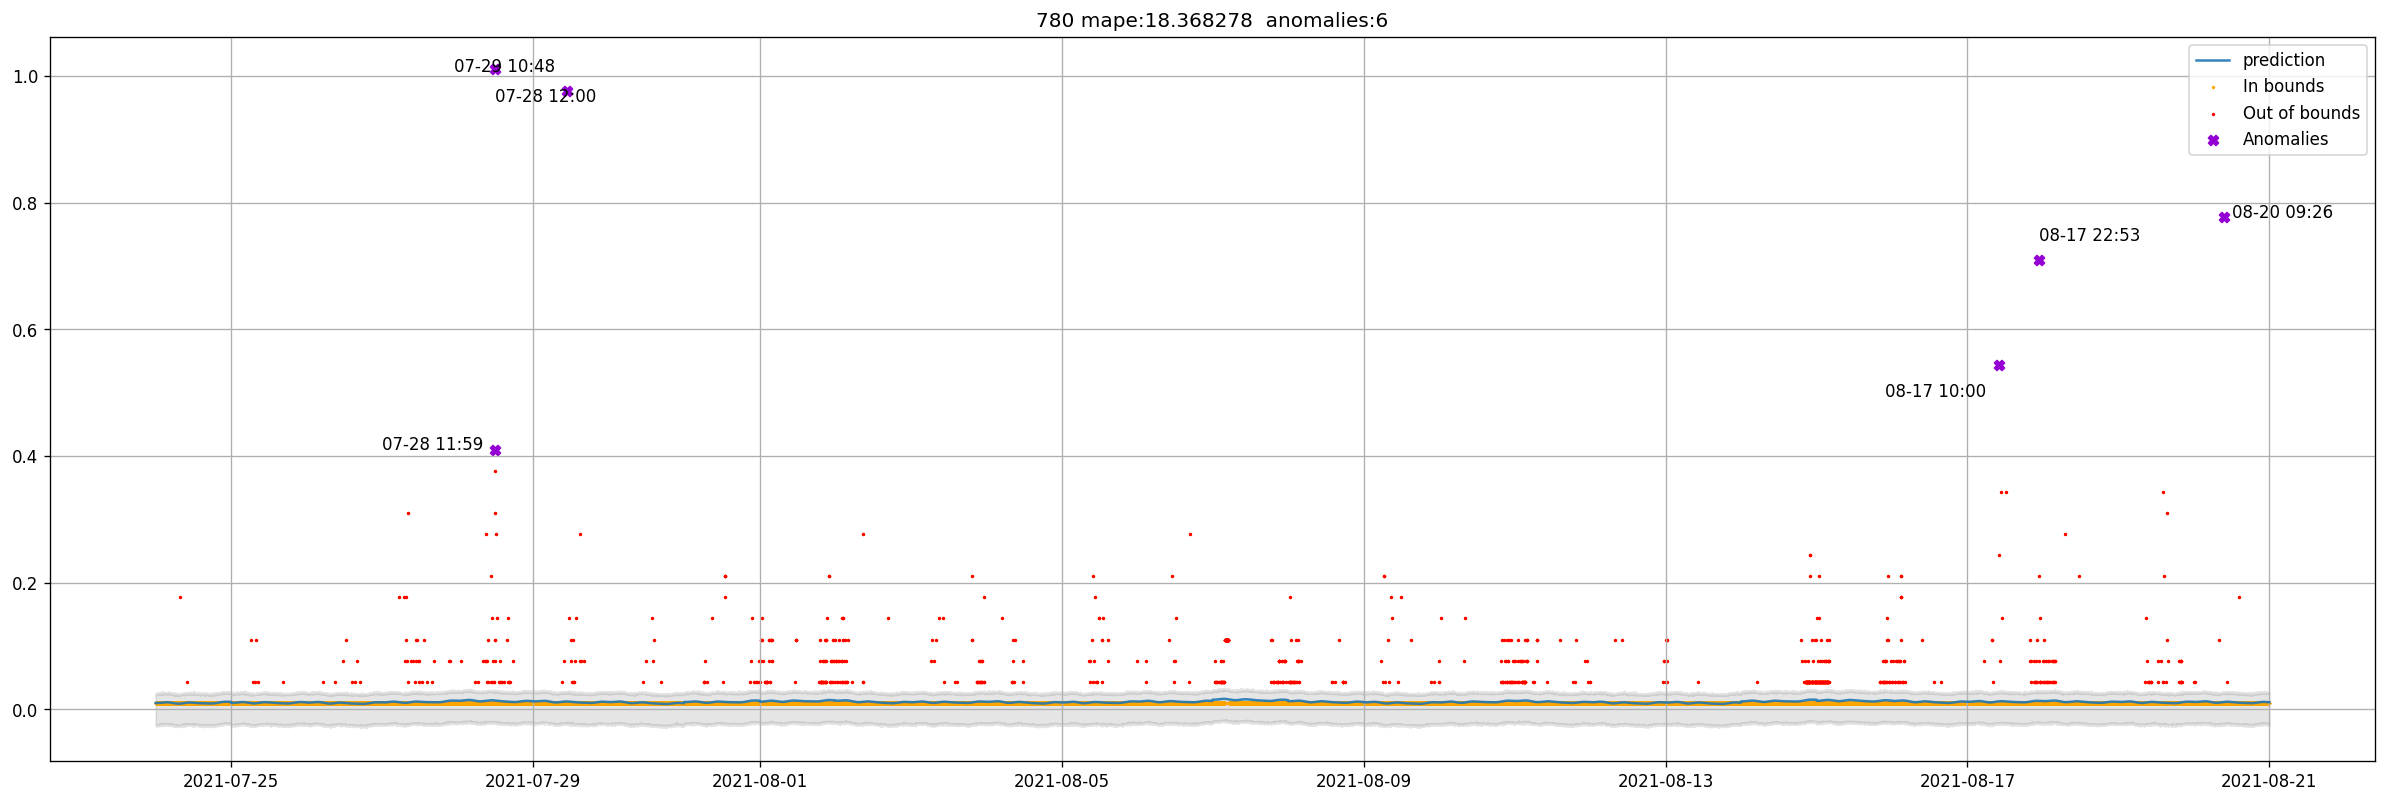

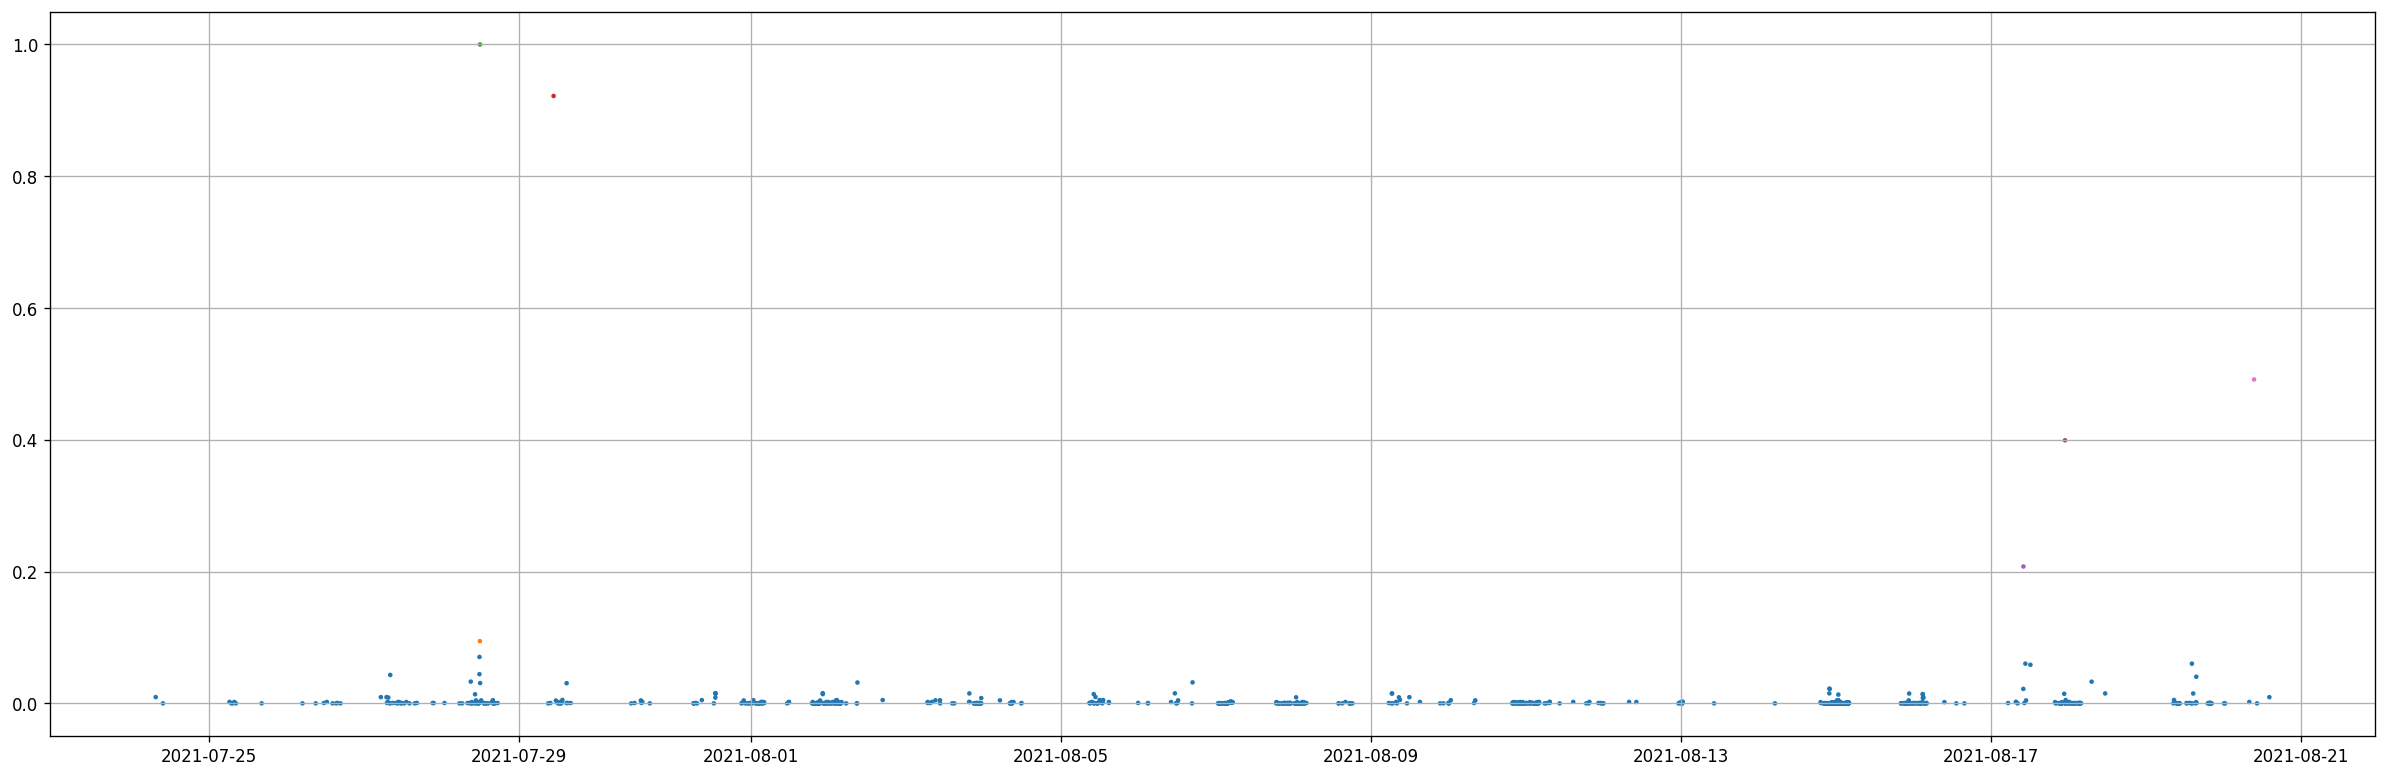

780 execution time :80.48010730743408 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

07-29 05:05
0.11526315789473683
0
07-29 05:47
0.11526315789473683
-0.05
07-29 08:07
0.06263157894736841
0.030000000000000002
07-29 08:21
0.01
-0.05
07-29 09:39
0.06263157894736841
0.030000000000000002
07-29 10:48
0.06263157894736841
0
07-30 05:04
0.06263157894736841
0
07-30 05:05
0.06263157894736841
-0.05
07-30 05:06
0.06263157894736841
0.030000000000000002
07-30 05:11
0.06263157894736841
-0.05
07-30 05:15
0.06263157894736841
0.030000000000000002
07-30 05:16
0.06263157894736841
0
07-30 05:23
0.06263157894736841
0
07-30 05:42
0.06263157894736841
-0.05
07-30 06:58
0.01
0.030000000000000002
07-30 06:59
0.01
-0.05
07-30 11:04
0.06263157894736841
0.030000000000000002
08-12 11:54
0.01
0


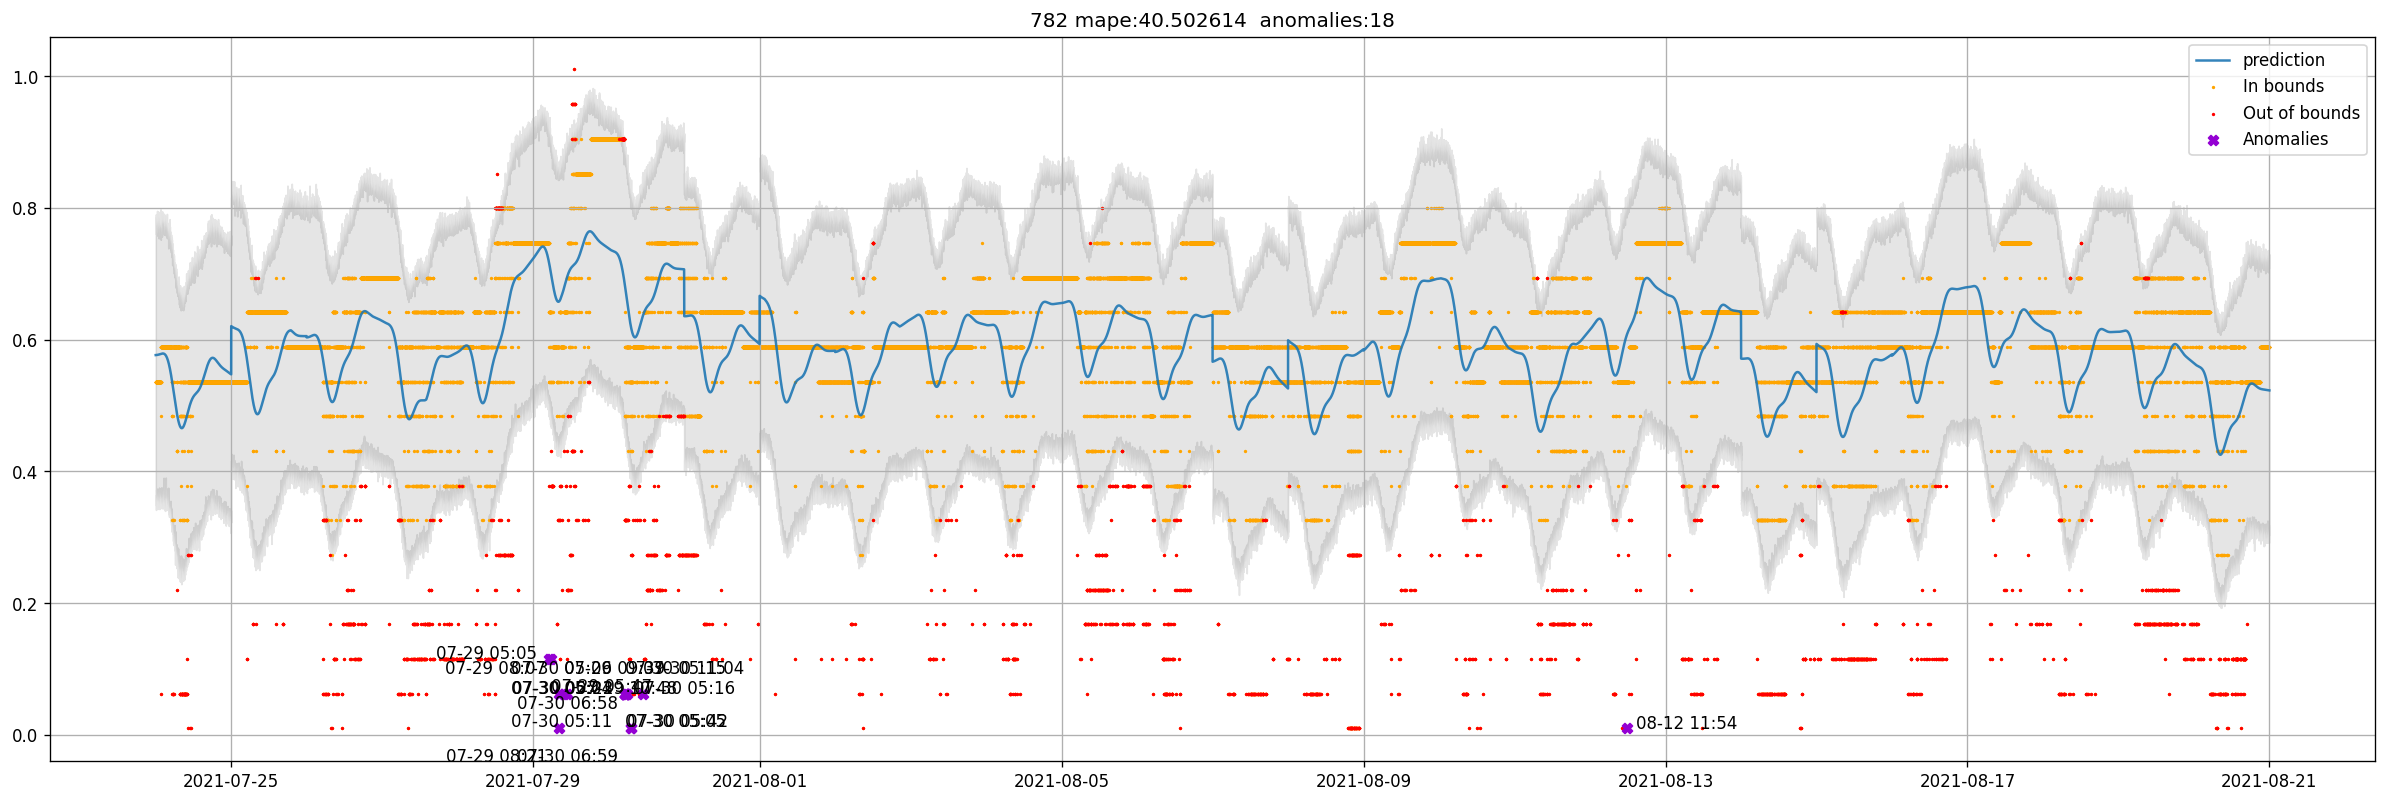

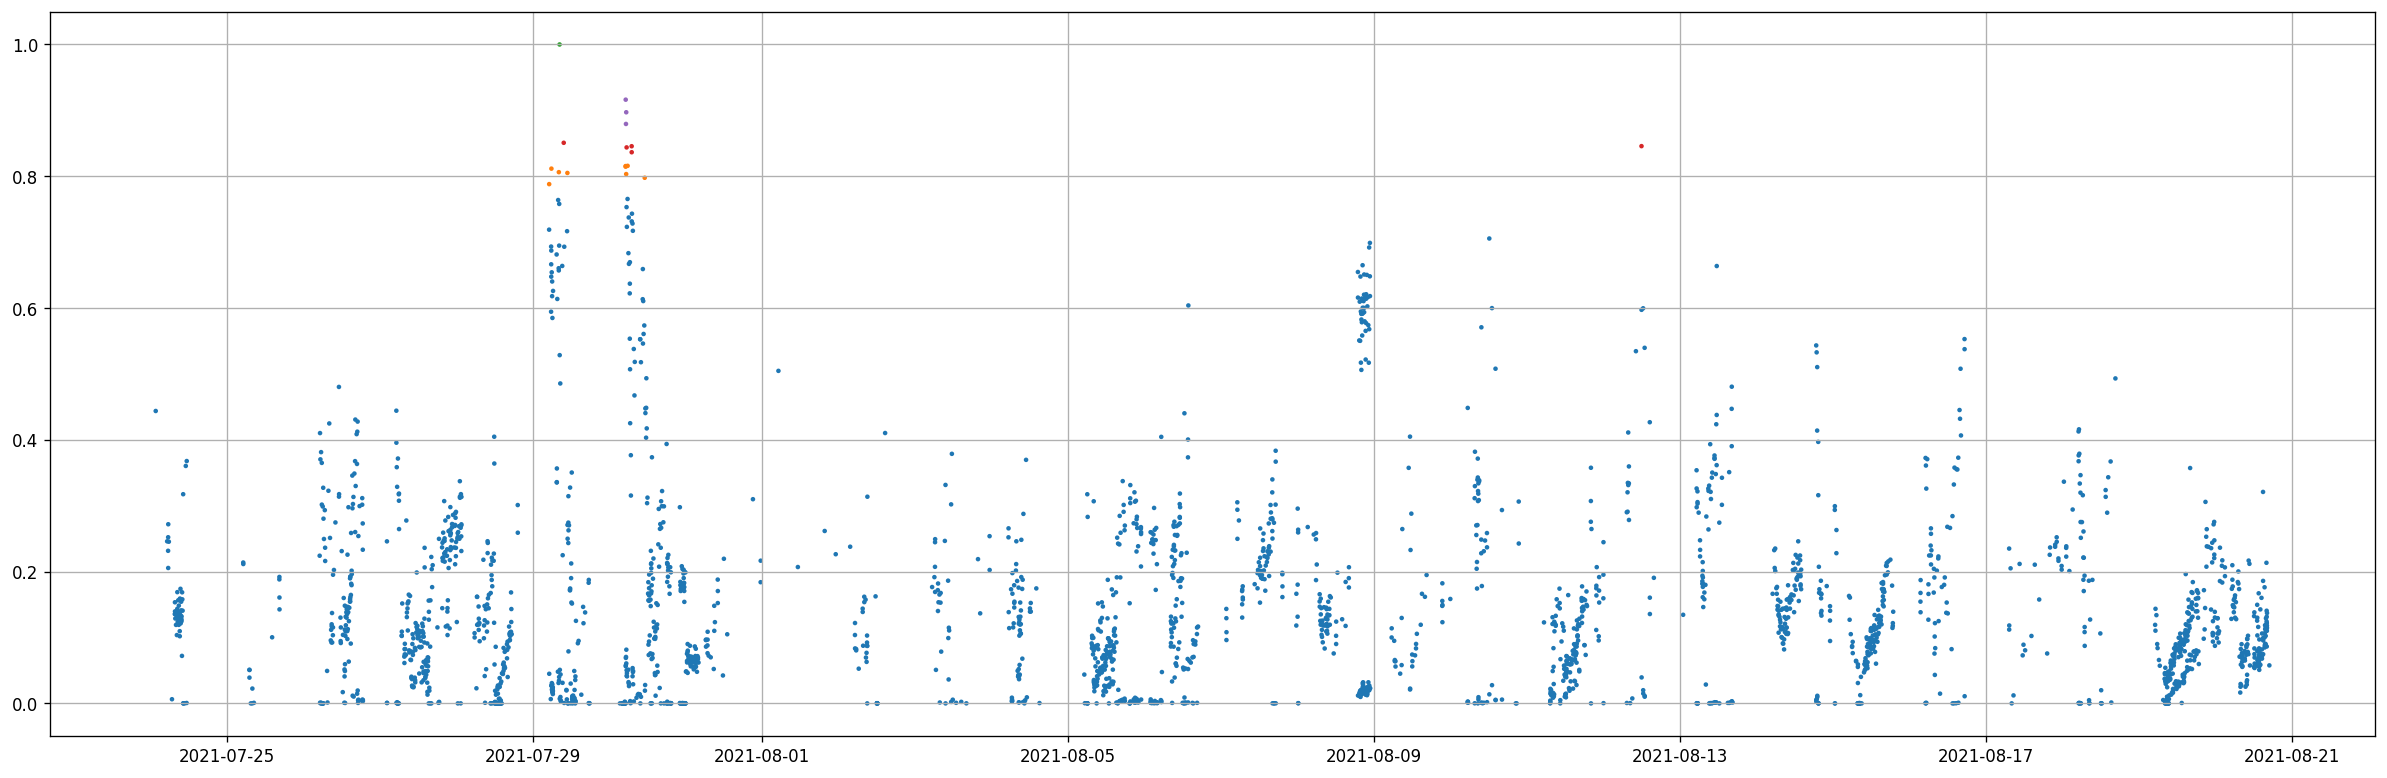

782 execution time :136.02533721923828 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

07-28 07:37
0.6733589594156498
0
07-30 08:54
1.01
-0.05
08-02 09:52
1.0035877897031553
0.030000000000000002
08-03 08:16
0.6893894851577618
-0.05
08-05 08:36
0.8144275859462347
0.030000000000000002
08-06 09:25
0.7150383263451408
0
08-10 13:32
0.6861833800093393
0
08-11 07:44
0.682977274860917
-0.05
08-19 08:39
0.6509162233766931
0.030000000000000002
08-20 06:24
0.7695421138683213
-0.05
08-20 13:45
0.734274957235675
0.030000000000000002
08-20 16:22
0.6733589594156498
0


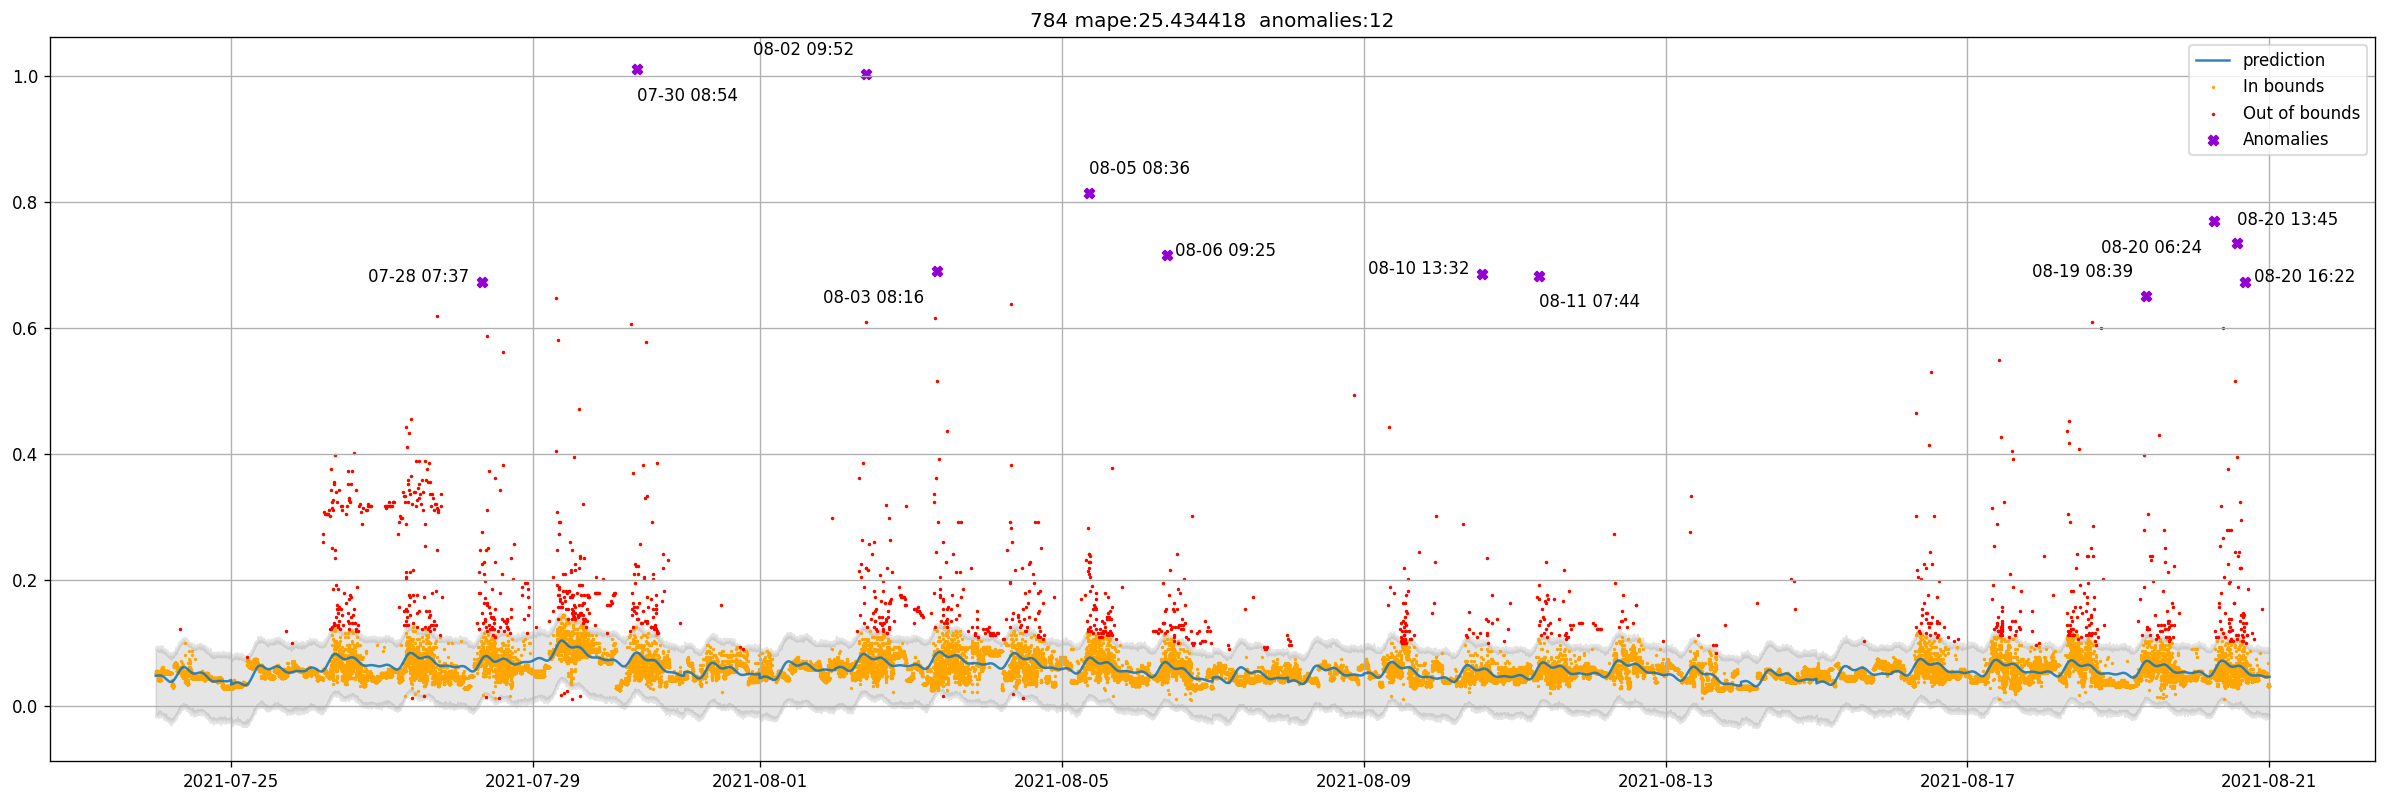

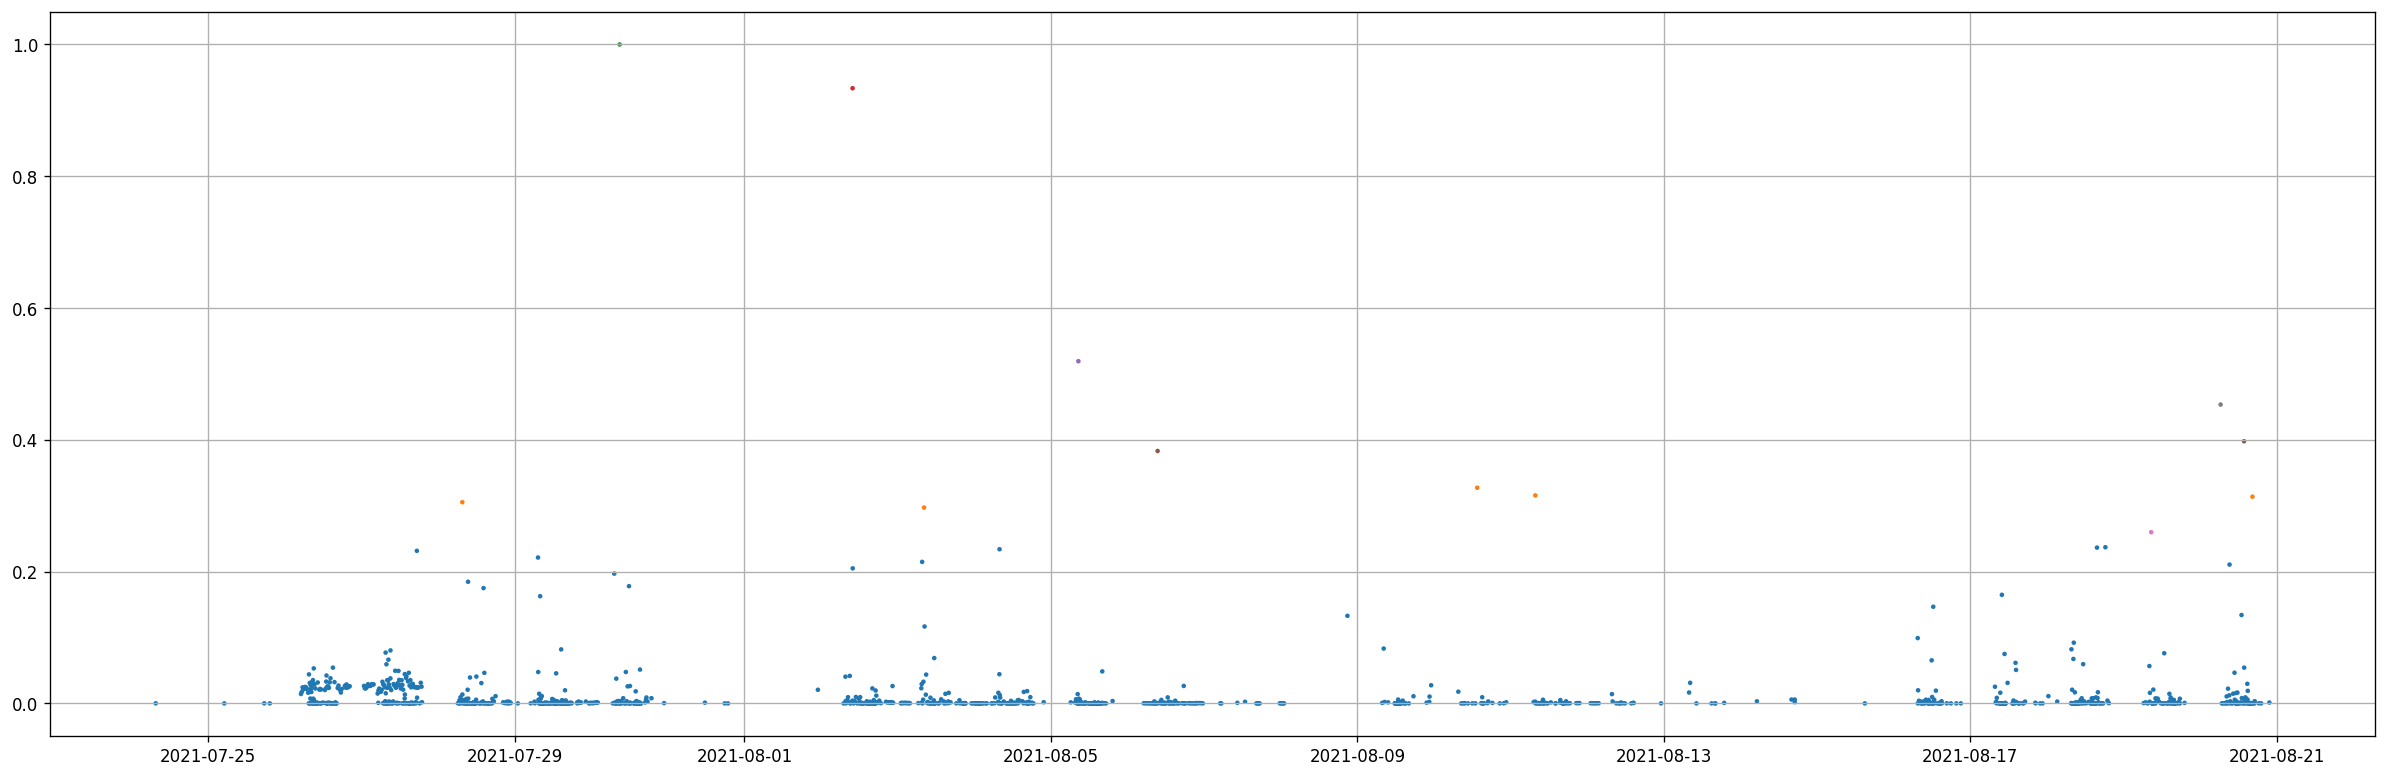

784 execution time :114.92731833457947 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

07-29 10:52
0.01
0
08-06 16:47
0.10999999999999999
-0.05
08-09 13:30
0.09888888888888889
0.030000000000000002
08-09 13:31
0.09888888888888889
-0.05
08-11 10:32
0.08777777777777779
0.030000000000000002
08-17 10:20
0.09888888888888889
0
08-17 10:22
0.12111111111111111
0
08-17 10:23
0.05444444444444444
-0.05
08-17 10:38
0.08777777777777779
0.030000000000000002
08-19 13:58
0.08777777777777779
-0.05
08-20 09:23
0.10999999999999999
0.030000000000000002
08-20 09:31
0.09888888888888889
0


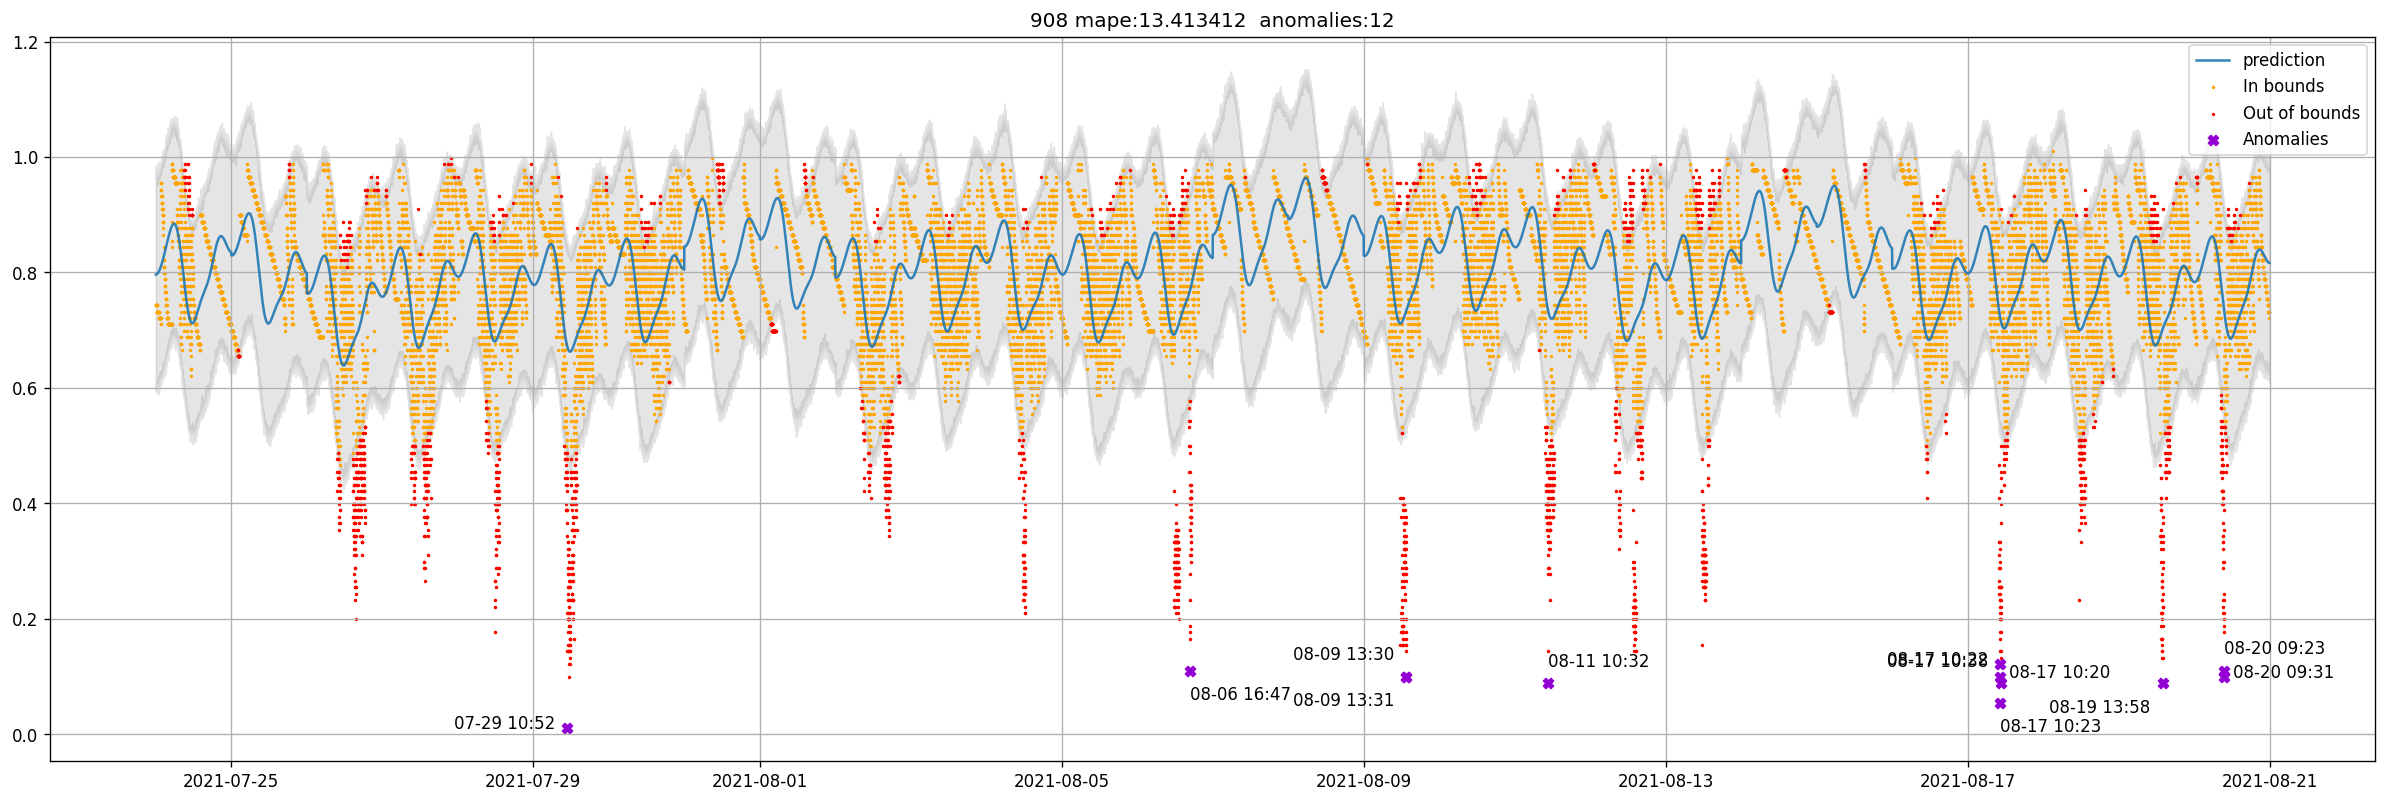

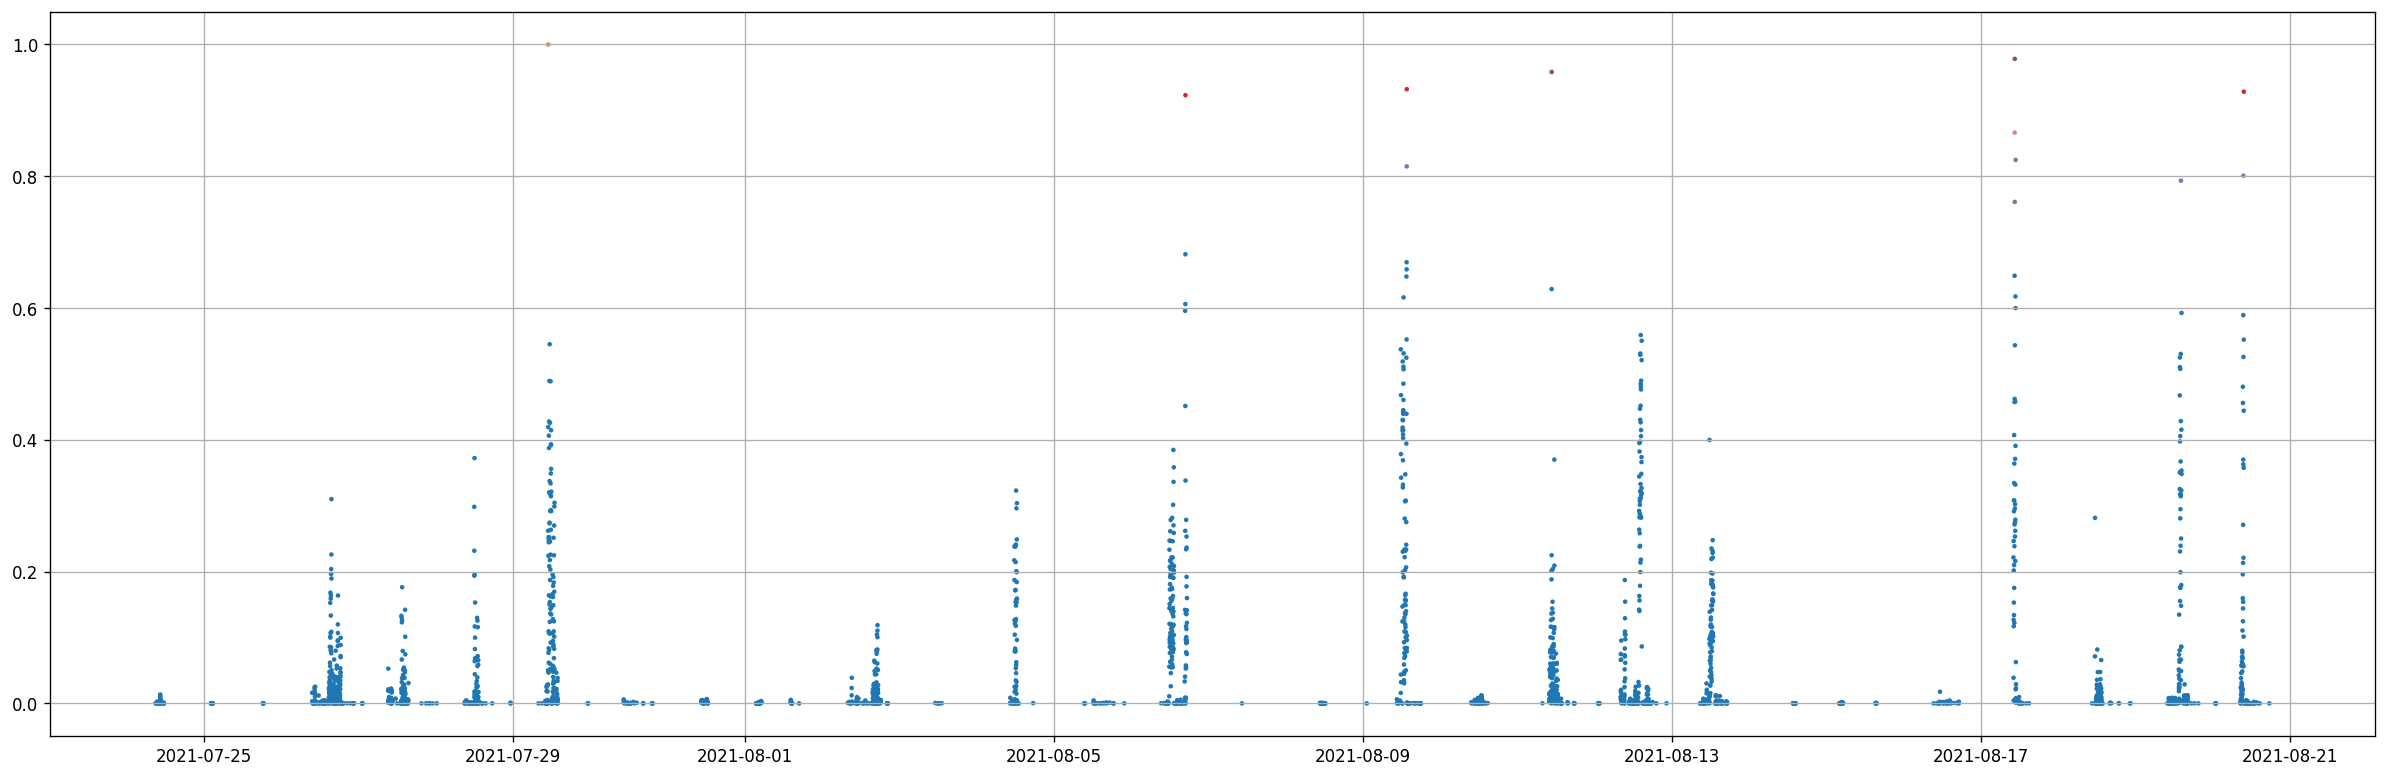

908 execution time :82.48722577095032 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

07-28 14:15
0.01
0
07-28 14:16
0.01
-0.05
07-28 14:17
0.01
0.030000000000000002
08-02 07:53
0.17585911293328427
-0.05
08-03 16:07
0.17921356690272128
0.030000000000000002
08-05 10:17
0.029754006708907925
0
08-06 09:19
0.14156913902348145
0
08-06 09:20
0.14156913902348145
-0.05
08-06 09:21
0.14156913902348145
0.030000000000000002
08-06 09:22
0.14156913902348145
-0.05
08-06 09:23
0.14156913902348145
0.030000000000000002
08-12 13:32
0.18070443533358227
0
08-18 10:42
0.10765188222139453
0


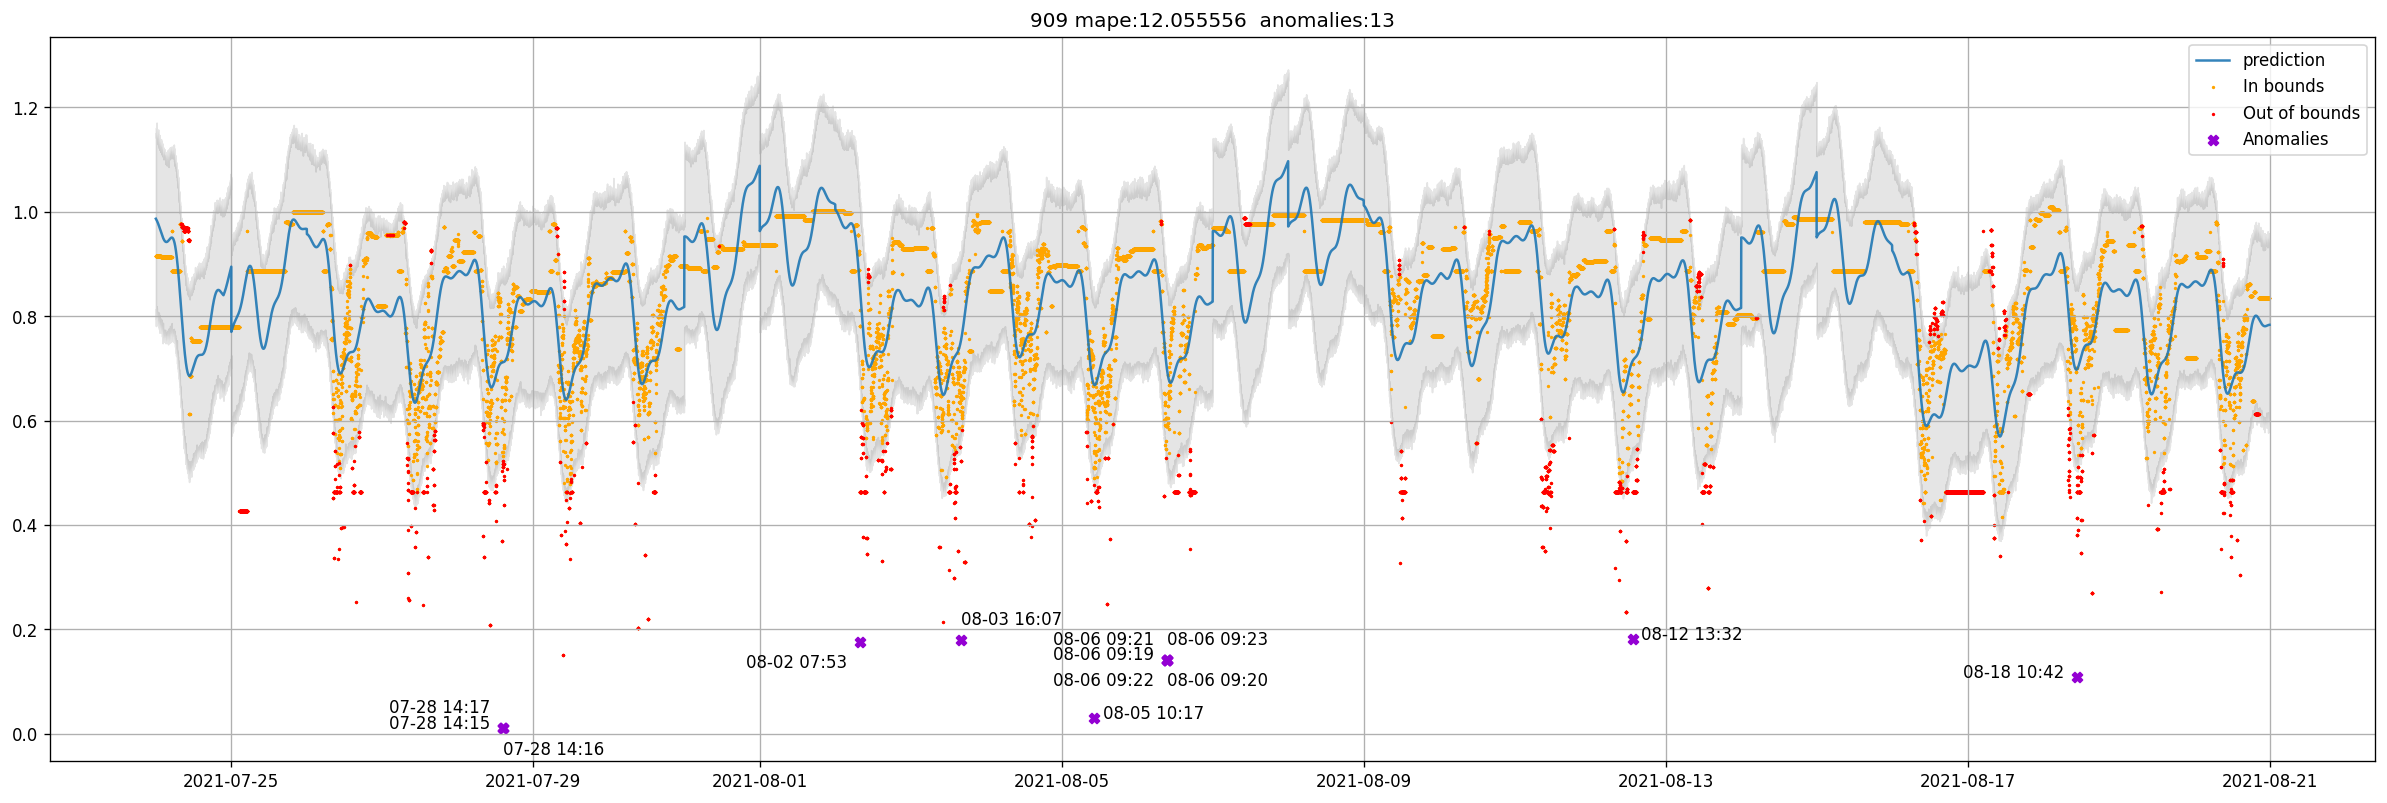

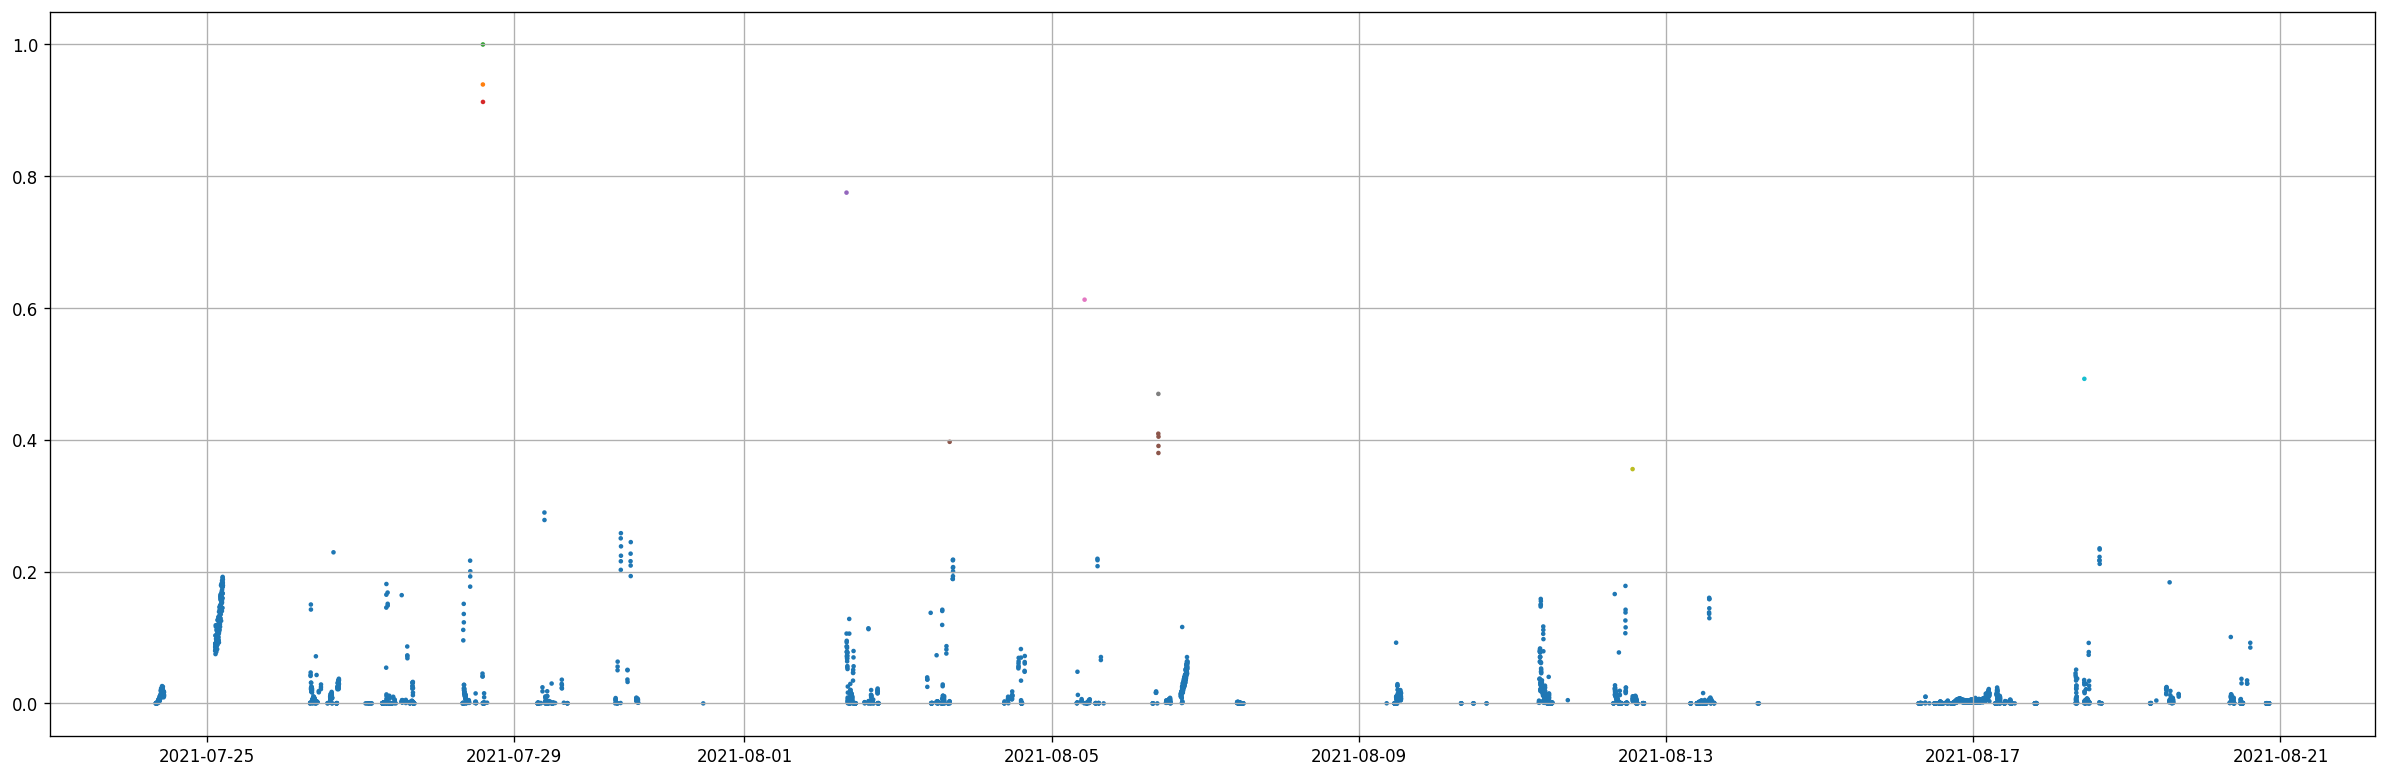

909 execution time :187.3494656085968 seconds


<IPython.core.display.Javascript object>

In [50]:
start_time_all = time.time()
scaler = MinMaxScaler()
tb = widgets.TabBar([columns[i] for i in range(len(columns))])
tmp=0

holidays = pd.DataFrame({
  'holiday': 'weekend',
  'ds': pd.to_datetime(['2021-07-25','2021-08-01','2021-08-08','2021-08-15' ]),
  'lower_window': -1,
  'upper_window': 0,
})

all_anomalies=pd.DataFrame()

for col in columns:
    start_time = time.time()
    
    ts=pd.DataFrame(
        ({'ds':df[col].index.to_numpy(), 
          'y':np.squeeze(scaler.fit_transform(df[col].values.reshape(-1,1)) )}))
    ts.index = pd.DatetimeIndex(df[col].index)
    ts=ts.asfreq(freq='60s',method='ffill')


    with warnings.catch_warnings():
      warnings.filterwarnings("ignore")
      model = Prophet(seasonality_mode = 'additive',growth='linear',yearly_seasonality=False,holidays=holidays,
                      interval_width=0.9)                                                       ################# PROPHET
      model.fit(ts)
      future = model.make_future_dataframe(periods=0,freq='min')   #?
      forecast = model.predict(future)

      #components = model.plot_components(forecast)



    ts_p =pd.DataFrame(list(forecast['yhat']))
    ts_p.index = pd.DatetimeIndex(list(forecast['ds']))
    ts_p=ts_p.asfreq(freq='60s',method='ffill')

    ts_c_upper = pd.DataFrame(list(forecast['yhat_upper']))
    ts_c_upper.index = pd.DatetimeIndex(list(forecast['ds']))
    ts_c_upper=ts_c_upper.asfreq(freq='60s',method='ffill')

    ts_c_lower = pd.DataFrame(list(forecast['yhat_lower']))
    ts_c_lower.index = pd.DatetimeIndex(list(forecast['ds']))
    ts_c_lower=ts_c_lower.asfreq(freq='60s',method='ffill')

    ts['y']=ts['y']+0.01        ################ATTENZIONE  MODIFICARE anche in arima

    ts_p=ts_p+0.01

    anomaly_scores=np.array([])
    
    sum=0;
    count=0;
    for i in range(0,len(ts.index),1):
      true_val=ts.iloc[i]['y']
      upper_val=ts_c_upper.iloc[i].to_numpy()[0]
      lower_val=ts_c_lower.iloc[i].to_numpy()[0]
      anomaly_score=0
      width=upper_val-lower_val

      k=2   #############################

      sum=sum+abs(true_val-ts_p.iloc[i].to_numpy()[0])/true_val
      count=count+1

      if true_val>upper_val :
        anomaly_score=pow((true_val-upper_val),5/2)/width*k
      else :
        if lower_val>true_val :
          anomaly_score=pow((lower_val-true_val),5/2)/width*k

      anomaly_scores=np.append(anomaly_scores,[anomaly_score])

    
    anomaly_scores=scaler.fit_transform(anomaly_scores.reshape(-1,1))
    anomaly_df=pd.DataFrame(anomaly_scores)
    anomaly_df.index = pd.DatetimeIndex(ts.index)
    anomaly_df=anomaly_df.asfreq(freq='60s',method='ffill')
    anomaly_df=anomaly_df[anomaly_df>0].dropna()

    clustering = DBSCAN(eps=0.02, min_samples=1).fit(anomaly_df)#DBSCAN


    labels=np.array(clustering.labels_)
    clusters, counts= np.unique(labels,return_counts=True)
    if counts[0]==1:
      labels[labels==0]=clusters.max()+1
    for i in range(1,len(clusters)):
      if counts[i]>10:
        labels[labels==clusters[i]]=0
    
    labels_df=pd.DataFrame(labels)
    labels_df.index=pd.DatetimeIndex(anomaly_df.index)

    

    out_of_bounds=labels_df[labels_df==0].dropna()
    anomalies_df=labels_df[labels_df > 0].dropna()

    all_anomalies=pd.concat([all_anomalies,pd.DataFrame(
        ({'x':anomalies_df.index.to_numpy(), 
          'y':np.full(len(anomalies_df.index),col)}))])


    mape_score=sum*100/count

    #print("mape: "+str(mape_score))

    index=np.squeeze(ts.index.to_numpy())
    ts_p=np.squeeze(ts_p.to_numpy())
    ts_c_upper=np.squeeze(ts_c_upper.to_numpy())
    ts_c_lower=np.squeeze(ts_c_lower.to_numpy())


    with tb.output_to(col):
      plt.rcParams.update({'figure.figsize': (25, 8), 'figure.dpi': 120})

      plt.plot(index,ts_p, label='prediction', alpha=0.9)
      plt.fill_between(index,
                      ts_c_upper,
                      ts_c_lower, color='k', alpha=.1)
      plt.scatter(x=index ,y=ts['y'], color='orange', label='In bounds',s=1)

      #print(out_of_bounds.head())
      #print(anomalies_df.head())

      plt.scatter(x=out_of_bounds.index , y=ts.loc[out_of_bounds.index]['y'], color='red', label='Out of bounds',s=1)
      plt.scatter(x=anomalies_df.index , y=ts.loc[anomalies_df.index]['y'], marker="X",color='darkviolet', label='Anomalies')

    
      hof=10000
      vof=0.05
      off=[(0,vof-0.02),
          (hof,0),
          (-13*hof,0),
          (0,-vof),
           (-13*hof,vof-0.02),
           (-13*hof,-vof),
           ]
      for j in anomalies_df.index: 
        cur_off=off[tmp%len(off)]
        tmp=tmp+1
        #print(str(j)[5:-3])
        #print(ts.loc[j][1])
        #print(cur_off[1])
        note=plt.annotate(str(j)[5:-3],(j,ts.loc[j][1]),xytext=(j+datetime.timedelta(0, cur_off[0]),ts.loc[j][1]+cur_off[1]),fontsize=10)
        
      plt.legend()
      plt.title("%s mape:%f  anomalies:%d"%(col,mape_score,len(anomalies_df.index)))
      plt.grid()
      plt.show()

      ############
      plt.rcParams.update({'figure.figsize': (25, 8), 'figure.dpi': 120})
      plt.scatter(x=anomaly_df.index ,y=anomaly_df, c=colormap[labels],s=3)
      plt.grid()
      plt.show()
      #component.show()
      ###########
      print(col+" execution time :"+str(time.time()-start_time)+" seconds")



In [ ]:
print("total execution time:"+str(time.time()-start_time_all)+" seconds")

In [ ]:
#plt.scatter(x=all_anomalies['x'],y=all_anomalies['y'],c=all_anomalies['y'].astype(int))

dates, counts= np.unique(all_anomalies['x'],return_counts=True)
for i in dates:
  if(len(all_anomalies.loc[all_anomalies['x']==i])>1):
    print(all_anomalies.loc[all_anomalies['x']==i])